In [1]:
import pandas as pd 
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pymer4.models import Lmer
from nltools.stats import circle_shift, zscore
from tqdm import tqdm

%matplotlib inline
sns.set_style("white")

base_dir = os.path.dirname(os.getcwd())

/Users/emma/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/Users/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv(os.path.join(base_dir,'Analyses','binned_connection_and_gaps_friends.csv'))

In [3]:
data.head()

,subID,partnerID,dyad,bin_num,gap_length_mean_1,gap_length_median_1,connection_1,num_turns_1,gap_length_mean_2,gap_length_median_2,...,connection_40,num_turns_40,gap_length_mean_60,gap_length_median_60,connection_60,num_turns_60,gap_length_mean_120,gap_length_median_120,connection_120,num_turns_120
0,101,204,101_204,0.0,490.861111,308.5,87.891333,144.0,580.962500,412.0,...,75.373333,4.0,720.000000,1040.0,74.24,3.0,1040.0,1040.0,71.08,1.0
1,204,101,101_204,0.0,490.861111,308.5,58.253000,144.0,580.962500,412.0,...,26.233333,4.0,720.000000,1040.0,17.85,3.0,1040.0,1040.0,12.04,1.0
2,101,204,101_204,1.0,NaN,NaN,NaN,NaN,378.234375,219.0,...,80.346667,9.0,1506.000000,410.0,77.20,3.0,560.0,560.0,77.40,2.0
3,204,101,101_204,1.0,NaN,NaN,NaN,NaN,378.234375,219.0,...,43.000000,9.0,1506.000000,410.0,43.00,3.0,560.0,560.0,23.66,2.0
4,101,204,101_204,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,92.533333,6.0,626.285714,440.0,82.14,7.0,279.0,279.0,77.64,1.0


# Effect of gap length on connection for each bin size

In [4]:
df_real = pd.DataFrame()
df_real = df_real.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.dropna().reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_zscore + bin_num_zscore + (1|subID) + (1|dyad)", data=data_subset_no_nans)
    model.fit()
        
    df_real.at[counter, 'num_bins'] = num_bins
    df_real.at[counter, 'bin_size'] = 600 / num_bins
    df_real.at[counter, 'beta'] = model.coefs['Estimate'][1]
    df_real.at[counter, 'p-val'] = model.coefs['P-val'][1]

    counter += 1
        
df_real.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_different_bins_friends.csv'), encoding='utf-8', index=False)
    

Formula: connection_2_zscore~gap_length_mean_2_zscore+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.348 	 AIC: 610.696

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.234  0.483

No random effect correlations specified

Fixed effects:

Formula: connection_3_zscore~gap_length_mean_3_zscore+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -421.671 	 AIC: 843.342

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.612  0.782
dyad      (Intercept)  0.268  0.518
Residual               0.238  0.488

No random effect correlations specified

Fixed effects:

Formula: connection_4_zscore~gap_length_mean_4_zscore+bin_num_zscore+(1|subID)+(1|dy

# Circle-shift each bin

In [5]:
df_shifted = pd.DataFrame()
df_shifted = df_shifted.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.dropna().reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    shifted_betas = []
    shifted_p_vals = []

    for _ in tqdm(range(100)): # change to 100 on cluster

        data_subset_no_nans[f'gap_length_mean_{num_bins}_shifted'] = data_subset_no_nans[f'gap_length_mean_{num_bins}_zscore'].groupby(data_subset_no_nans['dyad']).transform(circle_shift)
        model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_shifted + bin_num_zscore + (1|subID) + (1|dyad)", data=data_subset_no_nans)
        model.fit()

        shifted_betas.append(model.coefs['Estimate'][1])
        shifted_p_vals.append(model.coefs['P-val'][1])
        
    for i in range(len(shifted_betas)):
        df_shifted.at[counter, 'num_bins'] = num_bins
        df_shifted.at[counter, 'bin_size'] = 600 / num_bins
        df_shifted.at[counter, 'betas'] = shifted_betas[i]
        df_shifted.at[counter, 'p-val'] = shifted_p_vals[i]
        
        counter += 1
        
df_shifted.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_circle_shifted_friends.csv'), encoding='utf-8', index=False)
    

  1%|          | 1/100 [00:00<00:40,  2.44it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.166 	 AIC: 614.333

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.275  0.525
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:00<00:39,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.044 	 AIC: 614.087

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.264  0.514
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:01<00:39,  2.47it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.743 	 AIC: 613.486

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.259  0.509
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:01<00:38,  2.47it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.247 	 AIC: 610.493

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.233  0.483

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:02<00:38,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.171 	 AIC: 614.343

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.270  0.520
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:02<00:37,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.093 	 AIC: 614.185

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.281  0.530
Residual               0.234  0.483

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:02<00:37,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.623 	 AIC: 609.246

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.611  0.781
dyad      (Intercept)  0.252  0.502
Residual               0.231  0.480

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:03<00:36,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.382 	 AIC: 612.765

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.775
dyad      (Intercept)  0.256  0.506
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:03<00:36,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.587 	 AIC: 613.174

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:04<00:36,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.788 	 AIC: 611.576

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.604  0.777
dyad      (Intercept)  0.253  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:04<00:35,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.611 	 AIC: 613.221

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:04<00:35,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.450 	 AIC: 608.900

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.612  0.782
dyad      (Intercept)  0.252  0.502
Residual               0.230  0.480

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:05<00:35,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.720 	 AIC: 611.439

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:05<00:34,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.373 	 AIC: 610.747

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.234  0.483

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:06<00:34,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.239 	 AIC: 610.479

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.233  0.483

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:06<00:33,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.157 	 AIC: 614.313

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.276  0.526
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:06<00:33,  2.47it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.954 	 AIC: 613.907

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.774
dyad      (Intercept)  0.262  0.512
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:07<00:33,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.504 	 AIC: 613.007

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.506
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:07<00:32,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.590 	 AIC: 613.180

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:08<00:35,  2.24it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.896 	 AIC: 613.791

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.261  0.511
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:08<00:33,  2.32it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.947 	 AIC: 611.894

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.603  0.777
dyad      (Intercept)  0.254  0.504
Residual               0.236  0.485

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:08<00:33,  2.36it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.148 	 AIC: 614.297

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.268  0.518
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:09<00:32,  2.37it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -303.334 	 AIC: 606.669

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.618  0.786
dyad      (Intercept)  0.252  0.502
Residual               0.226  0.475

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:09<00:31,  2.41it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.660 	 AIC: 613.320

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.774
dyad      (Intercept)  0.258  0.508
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:10<00:30,  2.44it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.913 	 AIC: 613.826

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.261  0.511
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:10<00:30,  2.42it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.159 	 AIC: 614.319

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.269  0.519
Residual               0.237  0.486

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:11<00:29,  2.44it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.730 	 AIC: 613.460

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.259  0.509
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:11<00:29,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.535 	 AIC: 611.069

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:11<00:28,  2.45it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.462 	 AIC: 608.923

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.612  0.782
dyad      (Intercept)  0.252  0.502
Residual               0.230  0.480

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:12<00:28,  2.47it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.176 	 AIC: 614.353

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.774
dyad      (Intercept)  0.272  0.521
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:12<00:27,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.077 	 AIC: 612.154

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.603  0.776
dyad      (Intercept)  0.254  0.504
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:13<00:27,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.841 	 AIC: 613.681

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.260  0.510
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:13<00:27,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.485 	 AIC: 610.971

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.252  0.502
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:13<00:26,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.097 	 AIC: 614.194

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.281  0.530
Residual               0.234  0.483

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:14<00:26,  2.45it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.027 	 AIC: 610.053

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.252  0.502
Residual               0.232  0.482

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:14<00:25,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.800 	 AIC: 611.599

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.604  0.777
dyad      (Intercept)  0.253  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:15<00:25,  2.45it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.174 	 AIC: 614.348

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.774
dyad      (Intercept)  0.272  0.522
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:15<00:25,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.157 	 AIC: 614.315

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.276  0.526
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:15<00:24,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -303.502 	 AIC: 607.003

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.617  0.785
dyad      (Intercept)  0.252  0.502
Residual               0.226  0.476

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:16<00:24,  2.47it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.548 	 AIC: 611.097

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:16<00:24,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.310 	 AIC: 612.619

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.775
dyad      (Intercept)  0.255  0.505
Residual               0.237  0.486

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:17<00:23,  2.46it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.655 	 AIC: 609.309

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.610  0.781
dyad      (Intercept)  0.252  0.502
Residual               0.231  0.481

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:17<00:22,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.764 	 AIC: 613.528

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.259  0.509
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:17<00:22,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.100 	 AIC: 614.200

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.266  0.515
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:18<00:22,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.842 	 AIC: 611.683

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.604  0.777
dyad      (Intercept)  0.253  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:18<00:21,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.137 	 AIC: 614.274

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.268  0.517
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:19<00:21,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.119 	 AIC: 614.238

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.266  0.516
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:19<00:20,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.606 	 AIC: 611.212

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:19<00:20,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.918 	 AIC: 613.835

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.261  0.511
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:20<00:20,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.172 	 AIC: 610.343

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.233  0.483

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:20<00:19,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.522 	 AIC: 613.045

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:21<00:19,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.828 	 AIC: 611.656

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.604  0.777
dyad      (Intercept)  0.253  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:21<00:18,  2.53it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.604 	 AIC: 613.208

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:21<00:18,  2.53it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.110 	 AIC: 610.221

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.252  0.502
Residual               0.233  0.482

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:22<00:17,  2.56it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.939 	 AIC: 613.879

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.262  0.512
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:22<00:17,  2.56it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.712 	 AIC: 611.425

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:23<00:16,  2.58it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.172 	 AIC: 614.343

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.774
dyad      (Intercept)  0.272  0.521
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:23<00:16,  2.57it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.740 	 AIC: 613.479

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.259  0.509
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:23<00:16,  2.56it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.167 	 AIC: 614.335

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.275  0.524
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:24<00:15,  2.57it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.588 	 AIC: 613.177

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.775
dyad      (Intercept)  0.257  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:24<00:15,  2.55it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.984 	 AIC: 611.967

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.603  0.777
dyad      (Intercept)  0.254  0.504
Residual               0.236  0.485

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:24<00:14,  2.55it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.737 	 AIC: 609.475

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.610  0.781
dyad      (Intercept)  0.252  0.502
Residual               0.231  0.481

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:25<00:14,  2.55it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.037 	 AIC: 614.074

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.264  0.514
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:25<00:14,  2.54it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.538 	 AIC: 611.077

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:26<00:13,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.063 	 AIC: 614.126

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.264  0.514
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [00:26<00:13,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.122 	 AIC: 614.243

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.267  0.516
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [00:26<00:13,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.979 	 AIC: 613.958

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.776
dyad      (Intercept)  0.286  0.535
Residual               0.232  0.482

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [00:27<00:12,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.305 	 AIC: 612.610

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.776
dyad      (Intercept)  0.255  0.505
Residual               0.237  0.486

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [00:27<00:12,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.577 	 AIC: 611.155

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.253  0.503
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [00:28<00:11,  2.55it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.177 	 AIC: 614.353

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.774
dyad      (Intercept)  0.272  0.521
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [00:28<00:11,  2.56it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.767 	 AIC: 613.534

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.259  0.509
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [00:28<00:10,  2.57it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.419 	 AIC: 612.838

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.775
dyad      (Intercept)  0.256  0.506
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [00:29<00:10,  2.58it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.911 	 AIC: 611.822

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.603  0.777
dyad      (Intercept)  0.254  0.503
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [00:29<00:10,  2.58it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.744 	 AIC: 613.488

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.259  0.509
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [00:30<00:09,  2.56it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.218 	 AIC: 612.436

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.602  0.776
dyad      (Intercept)  0.255  0.505
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [00:30<00:09,  2.54it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.256 	 AIC: 610.511

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.233  0.483

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [00:30<00:09,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.907 	 AIC: 613.814

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.261  0.511
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [00:31<00:08,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.926 	 AIC: 613.852

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.261  0.511
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [00:31<00:08,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.832 	 AIC: 613.665

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.260  0.510
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [00:32<00:07,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.854 	 AIC: 613.707

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.260  0.510
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [00:32<00:07,  2.54it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.368 	 AIC: 610.735

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.234  0.483

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [00:32<00:07,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.126 	 AIC: 614.251

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.774
dyad      (Intercept)  0.279  0.528
Residual               0.234  0.484

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [00:33<00:06,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -302.782 	 AIC: 605.565

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.621  0.788
dyad      (Intercept)  0.253  0.503
Residual               0.223  0.473

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [00:33<00:06,  2.53it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.963 	 AIC: 611.927

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.603  0.777
dyad      (Intercept)  0.254  0.504
Residual               0.236  0.485

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [00:34<00:05,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.973 	 AIC: 611.946

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.603  0.777
dyad      (Intercept)  0.254  0.504
Residual               0.236  0.485

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [00:34<00:05,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.170 	 AIC: 614.340

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.270  0.520
Residual               0.236  0.486

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [00:34<00:05,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.400 	 AIC: 612.799

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.775
dyad      (Intercept)  0.256  0.506
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [00:35<00:04,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.846 	 AIC: 613.692

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.260  0.510
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [00:35<00:04,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.898 	 AIC: 613.796

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.261  0.511
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [00:36<00:03,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.968 	 AIC: 613.936

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.262  0.512
Residual               0.238  0.487

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [00:36<00:03,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.999 	 AIC: 613.998

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.774
dyad      (Intercept)  0.263  0.513
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [00:36<00:03,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.655 	 AIC: 613.310

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.774
dyad      (Intercept)  0.258  0.508
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [00:37<00:02,  2.52it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.518 	 AIC: 609.036

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.611  0.782
dyad      (Intercept)  0.252  0.502
Residual               0.230  0.480

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [00:37<00:02,  2.50it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -303.384 	 AIC: 606.767

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.618  0.786
dyad      (Intercept)  0.252  0.502
Residual               0.226  0.475

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [00:38<00:02,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.153 	 AIC: 614.306

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.598  0.773
dyad      (Intercept)  0.269  0.518
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [00:38<00:01,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.627 	 AIC: 613.254

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.600  0.774
dyad      (Intercept)  0.258  0.507
Residual               0.237  0.487

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [00:38<00:01,  2.51it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -306.299 	 AIC: 612.597

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.601  0.776
dyad      (Intercept)  0.255  0.505
Residual               0.237  0.486

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [00:39<00:00,  2.48it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -307.165 	 AIC: 614.330

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.599  0.774
dyad      (Intercept)  0.274  0.524
Residual               0.235  0.485

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [00:39<00:00,  2.49it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -305.152 	 AIC: 610.305

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.779
dyad      (Intercept)  0.252  0.502
Residual               0.233  0.482

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 260	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -304.152 	 AIC: 608.304

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.613  0.783
dyad      (Intercept)  0.252  0.502
Residual               0.229  0.478

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:00<00:44,  2.20it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.898 	 AIC: 847.796

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:00<00:44,  2.20it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.251 	 AIC: 850.503

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.285  0.534
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:01<00:43,  2.21it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.286 	 AIC: 850.572

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.293  0.541
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:01<00:43,  2.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.000 	 AIC: 850.001

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.281  0.530
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:02<00:42,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.351 	 AIC: 848.702

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.275  0.525
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:02<00:42,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.844 	 AIC: 849.689

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.279  0.528
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:03<00:41,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.939 	 AIC: 847.878

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:03<00:40,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.032 	 AIC: 850.064

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.281  0.530
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:04<00:40,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.178 	 AIC: 850.357

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:04<00:39,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.748 	 AIC: 849.496

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.278  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:04<00:38,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -422.094 	 AIC: 844.189

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.611  0.782
dyad      (Intercept)  0.269  0.518
Residual               0.239  0.489

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:05<00:38,  2.31it/s]

Model failed to converge with max|grad| = 0.0148497 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.312 	 AIC: 850.624

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.604  0.777
dyad      (Intercept)  0.289  0.538
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:05<00:37,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.945 	 AIC: 849.891

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.302  0.550
Residual               0.240  0.490

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:06<00:38,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.084 	 AIC: 850.169

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.282  0.531
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:06<00:37,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.074 	 AIC: 848.149

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.274  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:07<00:36,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.207 	 AIC: 850.413

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.284  0.533
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:07<00:36,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.012 	 AIC: 846.025

Random effects:

                 Name    Var   Std
subID     (Intercept)  0.609  0.78
dyad      (Intercept)  0.270  0.52
Residual               0.240  0.49

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:07<00:36,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.980 	 AIC: 849.959

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.280  0.529
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:08<00:35,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.421 	 AIC: 846.842

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.272  0.521
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:08<00:35,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.267 	 AIC: 850.533

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.286  0.534
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:09<00:35,  2.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.033 	 AIC: 850.065

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.300  0.548
Residual               0.240  0.490

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:09<00:34,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.316 	 AIC: 850.631

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.290  0.538
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:10<00:34,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.183 	 AIC: 850.366

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:10<00:36,  2.07it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.667 	 AIC: 849.333

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:11<00:35,  2.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.310 	 AIC: 850.619

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.288  0.537
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:11<00:34,  2.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.273 	 AIC: 850.546

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.294  0.542
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:12<00:33,  2.19it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.211 	 AIC: 850.422

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.284  0.533
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:12<00:32,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.174 	 AIC: 850.348

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:12<00:31,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.683 	 AIC: 849.367

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:13<00:31,  2.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.566 	 AIC: 849.132

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.526
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:13<00:30,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.691 	 AIC: 849.382

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:14<00:30,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.291 	 AIC: 848.581

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.275  0.524
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:14<00:30,  2.23it/s]

Model failed to converge with max|grad| = 0.00811564 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.123 	 AIC: 850.245

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.282  0.531
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:15<00:29,  2.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.298 	 AIC: 850.597

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.290  0.539
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:15<00:29,  2.20it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.050 	 AIC: 850.101

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.281  0.530
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:16<00:28,  2.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.759 	 AIC: 849.517

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.278  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:16<00:27,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.984 	 AIC: 847.968

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.274  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:17<00:27,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.464 	 AIC: 848.927

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.276  0.525
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:17<00:27,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.160 	 AIC: 850.320

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:17<00:26,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.091 	 AIC: 850.182

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.299  0.547
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:18<00:26,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -422.491 	 AIC: 844.982

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.610  0.781
dyad      (Intercept)  0.269  0.519
Residual               0.239  0.489

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:18<00:25,  2.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.872 	 AIC: 847.744

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:19<00:25,  2.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.307 	 AIC: 850.615

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.289  0.537
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:19<00:24,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.292 	 AIC: 850.584

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.287  0.536
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:20<00:24,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.650 	 AIC: 849.300

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.526
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:20<00:23,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.899 	 AIC: 847.798

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:21<00:23,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.293 	 AIC: 850.585

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.287  0.536
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:21<00:23,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.234 	 AIC: 850.467

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.295  0.543
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:21<00:22,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.317 	 AIC: 850.634

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.289  0.538
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:22<00:21,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.226 	 AIC: 850.451

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.295  0.543
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:22<00:21,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.850 	 AIC: 847.700

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.522
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:23<00:21,  2.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.987 	 AIC: 847.974

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.274  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:23<00:20,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.905 	 AIC: 849.811

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.279  0.529
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:24<00:20,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.227 	 AIC: 850.455

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.284  0.533
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:24<00:19,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.249 	 AIC: 850.498

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.285  0.534
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:24<00:19,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -422.982 	 AIC: 845.964

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.609  0.781
dyad      (Intercept)  0.270  0.520
Residual               0.240  0.490

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:25<00:18,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.317 	 AIC: 846.635

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.271  0.521
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:25<00:18,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.958 	 AIC: 847.916

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:26<00:17,  2.30it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.172 	 AIC: 850.344

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:26<00:17,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.512 	 AIC: 849.023

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.276  0.526
Residual               0.243  0.492

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:27<00:17,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.288 	 AIC: 850.575

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.293  0.541
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:27<00:16,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.898 	 AIC: 847.796

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:28<00:16,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.641 	 AIC: 847.282

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.272  0.522
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:28<00:15,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.136 	 AIC: 850.273

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.298  0.546
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:28<00:15,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.941 	 AIC: 847.881

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.607  0.779
dyad      (Intercept)  0.273  0.523
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [00:29<00:14,  2.30it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.646 	 AIC: 849.292

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.526
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [00:29<00:14,  2.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.095 	 AIC: 850.189

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.282  0.531
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [00:30<00:14,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.310 	 AIC: 850.620

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.288  0.537
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [00:30<00:13,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.923 	 AIC: 849.846

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.280  0.529
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [00:31<00:13,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.671 	 AIC: 849.342

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [00:31<00:12,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.261 	 AIC: 850.521

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.294  0.542
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [00:31<00:12,  2.27it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.305 	 AIC: 850.610

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.288  0.536
Residual               0.243  0.492

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [00:32<00:11,  2.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.187 	 AIC: 850.375

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [00:32<00:11,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.183 	 AIC: 850.365

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [00:33<00:11,  2.18it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.347 	 AIC: 848.694

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.275  0.525
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [00:33<00:10,  2.20it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.394 	 AIC: 846.787

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.271  0.521
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [00:34<00:10,  2.10it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.552 	 AIC: 849.103

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.276  0.526
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [00:34<00:10,  2.00it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -422.875 	 AIC: 845.749

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.609  0.781
dyad      (Intercept)  0.270  0.520
Residual               0.240  0.490

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [00:35<00:10,  1.98it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.785 	 AIC: 849.571

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.278  0.528
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [00:35<00:09,  2.01it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -421.657 	 AIC: 843.314

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.612  0.782
dyad      (Intercept)  0.268  0.518
Residual               0.238  0.488

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [00:36<00:09,  2.06it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.284 	 AIC: 850.568

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.293  0.541
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [00:36<00:08,  2.10it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -423.494 	 AIC: 846.988

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.608  0.780
dyad      (Intercept)  0.272  0.521
Residual               0.241  0.491

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [00:37<00:07,  2.13it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.249 	 AIC: 850.498

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.285  0.534
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [00:37<00:07,  2.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.707 	 AIC: 849.413

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.278  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [00:38<00:06,  2.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.317 	 AIC: 850.634

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.290  0.538
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [00:38<00:06,  2.17it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.363 	 AIC: 848.725

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.779
dyad      (Intercept)  0.275  0.525
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [00:39<00:05,  2.20it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.713 	 AIC: 849.425

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.278  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [00:39<00:05,  2.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.655 	 AIC: 849.310

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.277  0.527
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [00:39<00:04,  2.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.472 	 AIC: 848.944

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.276  0.525
Residual               0.242  0.492

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [00:40<00:04,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.196 	 AIC: 850.391

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.284  0.533
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [00:40<00:03,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.539 	 AIC: 849.079

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.276  0.526
Residual               0.243  0.492

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [00:41<00:03,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -424.982 	 AIC: 849.963

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.280  0.529
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [00:41<00:03,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.092 	 AIC: 850.183

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.282  0.531
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [00:42<00:02,  2.30it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.246 	 AIC: 850.492

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.606  0.778
dyad      (Intercept)  0.294  0.543
Residual               0.242  0.491

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [00:42<00:02,  2.30it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.199 	 AIC: 850.399

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.284  0.533
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [00:43<00:01,  2.29it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.189 	 AIC: 850.378

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [00:43<00:01,  2.28it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.012 	 AIC: 850.025

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.281  0.530
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [00:43<00:00,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.181 	 AIC: 850.362

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.283  0.532
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [00:44<00:00,  2.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.290 	 AIC: 850.580

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.287  0.535
Residual               0.243  0.493

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 390	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -425.307 	 AIC: 850.615

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.605  0.778
dyad      (Intercept)  0.288  0.536
Residual               0.243  0.492

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:00<00:50,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.032 	 AIC: 1108.063

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.272  0.522
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:01<00:50,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.926 	 AIC: 1109.851

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.292  0.540
Residual               0.270  0.519

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:01<00:49,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.721 	 AIC: 1109.442

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:02<00:49,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.973 	 AIC: 1109.947

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.278  0.527
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:02<00:49,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.121 	 AIC: 1110.243

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.280  0.529
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:03<00:49,  1.91it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.164 	 AIC: 1110.327

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.288  0.536
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:03<00:48,  1.91it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.745 	 AIC: 1109.490

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:04<00:48,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.218 	 AIC: 1110.436

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.282  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:04<00:47,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.207 	 AIC: 1108.415

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.273  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:05<00:48,  1.86it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.181 	 AIC: 1110.363

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.281  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:05<00:47,  1.86it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.242 	 AIC: 1110.483

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.284  0.533
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:06<00:46,  1.89it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.161 	 AIC: 1110.321

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.280  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:06<00:45,  1.91it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.812 	 AIC: 1109.625

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:07<00:44,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.228 	 AIC: 1110.456

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.282  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:07<00:43,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.078 	 AIC: 1110.156

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:08<00:42,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.750 	 AIC: 1109.499

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:08<00:42,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.467 	 AIC: 1106.934

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.271  0.520
Residual               0.270  0.519

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:09<00:41,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.732 	 AIC: 1109.464

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:09<00:40,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.955 	 AIC: 1107.910

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.272  0.522
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:10<00:40,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.238 	 AIC: 1110.475

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.284  0.533
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:10<00:40,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.198 	 AIC: 1110.396

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.281  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:11<00:39,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.228 	 AIC: 1110.455

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.533
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:11<00:39,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.801 	 AIC: 1109.602

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:12<00:38,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.145 	 AIC: 1110.290

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.288  0.537
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:12<00:39,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.066 	 AIC: 1110.131

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:13<00:38,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.233 	 AIC: 1110.465

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.283  0.532
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:13<00:37,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.216 	 AIC: 1106.433

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.270  0.520
Residual               0.270  0.519

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:14<00:36,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.329 	 AIC: 1108.659

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:14<00:36,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.177 	 AIC: 1110.354

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.287  0.536
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:15<00:36,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.044 	 AIC: 1110.088

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:16<00:36,  1.90it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.241 	 AIC: 1110.482

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.284  0.533
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:16<00:35,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.690 	 AIC: 1109.381

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:17<00:34,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.797 	 AIC: 1109.594

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:17<00:34,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.236 	 AIC: 1110.471

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.534
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:18<00:33,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.365 	 AIC: 1108.731

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:18<00:32,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.290 	 AIC: 1108.580

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.273  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:19<00:31,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -552.901 	 AIC: 1105.801

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.588  0.767
dyad      (Intercept)  0.269  0.519
Residual               0.269  0.519

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:19<00:31,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.354 	 AIC: 1108.708

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:20<00:30,  1.99it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -552.897 	 AIC: 1105.793

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.588  0.767
dyad      (Intercept)  0.269  0.519
Residual               0.269  0.519

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:20<00:30,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.239 	 AIC: 1110.477

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.283  0.532
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:21<00:29,  2.00it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.885 	 AIC: 1109.771

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.277  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:21<00:29,  1.99it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.112 	 AIC: 1110.224

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.280  0.529
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:22<00:29,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.176 	 AIC: 1110.353

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.281  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:22<00:28,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.956 	 AIC: 1109.912

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.278  0.527
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:23<00:27,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.756 	 AIC: 1107.513

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.271  0.521
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:23<00:27,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.161 	 AIC: 1110.322

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.288  0.536
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:24<00:26,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.128 	 AIC: 1110.257

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.280  0.529
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:24<00:26,  1.99it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -549.401 	 AIC: 1098.801

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.592  0.770
dyad      (Intercept)  0.265  0.515
Residual               0.265  0.514

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:25<00:26,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.060 	 AIC: 1110.120

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:25<00:25,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.406 	 AIC: 1108.813

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:26<00:25,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.195 	 AIC: 1110.390

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.281  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:26<00:24,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.225 	 AIC: 1110.451

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.282  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:27<00:24,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -549.939 	 AIC: 1099.879

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.592  0.769
dyad      (Intercept)  0.265  0.515
Residual               0.265  0.515

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:27<00:23,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.095 	 AIC: 1108.190

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.273  0.522
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:28<00:22,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.386 	 AIC: 1108.771

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:28<00:22,  1.97it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.676 	 AIC: 1109.352

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.295  0.543
Residual               0.269  0.519

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:29<00:21,  1.99it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.423 	 AIC: 1106.845

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.270  0.520
Residual               0.270  0.519

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:29<00:20,  2.01it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.736 	 AIC: 1109.473

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:30<00:20,  1.99it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.051 	 AIC: 1110.102

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:30<00:20,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.225 	 AIC: 1110.449

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.534
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:31<00:19,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.226 	 AIC: 1110.452

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.282  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:31<00:19,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.526 	 AIC: 1109.052

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.275  0.524
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:32<00:18,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.232 	 AIC: 1110.464

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.534
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:32<00:18,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.233 	 AIC: 1110.466

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.533
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:33<00:17,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.324 	 AIC: 1108.649

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [00:33<00:17,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.236 	 AIC: 1110.473

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.283  0.532
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [00:34<00:17,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.020 	 AIC: 1108.041

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.272  0.522
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [00:34<00:16,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.768 	 AIC: 1109.535

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [00:35<00:16,  1.90it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.810 	 AIC: 1109.619

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [00:35<00:15,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.833 	 AIC: 1109.666

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.277  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [00:36<00:14,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -552.717 	 AIC: 1105.434

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.588  0.767
dyad      (Intercept)  0.269  0.518
Residual               0.269  0.519

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [00:36<00:14,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.235 	 AIC: 1110.471

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.534
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [00:37<00:13,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.664 	 AIC: 1109.328

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.275  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [00:37<00:13,  1.96it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.933 	 AIC: 1109.866

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.277  0.527
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [00:38<00:12,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.658 	 AIC: 1109.315

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.275  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [00:38<00:12,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.012 	 AIC: 1110.023

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.278  0.527
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [00:39<00:11,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.375 	 AIC: 1108.751

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [00:40<00:11,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.340 	 AIC: 1108.680

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.523
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [00:40<00:10,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.010 	 AIC: 1110.021

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.278  0.527
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [00:41<00:10,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.999 	 AIC: 1107.998

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.272  0.522
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [00:41<00:10,  1.90it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.181 	 AIC: 1110.362

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.281  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [00:42<00:09,  1.91it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.716 	 AIC: 1107.432

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.271  0.521
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [00:42<00:08,  1.90it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.196 	 AIC: 1110.392

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.287  0.535
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [00:43<00:08,  1.90it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.932 	 AIC: 1109.863

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.277  0.527
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [00:43<00:07,  1.89it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.232 	 AIC: 1110.464

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.285  0.534
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [00:44<00:07,  1.92it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.089 	 AIC: 1110.178

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [00:44<00:06,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.225 	 AIC: 1110.451

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.282  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [00:45<00:06,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.203 	 AIC: 1110.406

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.286  0.535
Residual               0.271  0.520

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [00:45<00:05,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.818 	 AIC: 1109.637

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.526
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [00:46<00:05,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.165 	 AIC: 1110.330

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.280  0.530
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [00:46<00:04,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.760 	 AIC: 1109.519

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [00:47<00:04,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.235 	 AIC: 1110.471

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.283  0.532
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [00:47<00:03,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.226 	 AIC: 1110.453

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.283  0.532
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [00:48<00:03,  1.93it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.060 	 AIC: 1110.120

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.279  0.528
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [00:48<00:02,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -553.509 	 AIC: 1107.018

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.271  0.520
Residual               0.270  0.519

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [00:49<00:02,  1.98it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -554.557 	 AIC: 1109.114

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.275  0.524
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [00:49<00:01,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.201 	 AIC: 1110.402

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.281  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [00:50<00:01,  1.94it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.217 	 AIC: 1110.434

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.282  0.531
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [00:50<00:00,  1.95it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.114 	 AIC: 1110.228

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.280  0.529
Residual               0.271  0.521

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 520	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -555.082 	 AIC: 1110.164

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.289  0.538
Residual               0.270  0.520

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:00<00:53,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.803 	 AIC: 1357.607

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.278  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:01<00:52,  1.87it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.645 	 AIC: 1359.290

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.292  0.540
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:01<00:52,  1.86it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.803 	 AIC: 1359.606

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.286  0.535
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:02<00:51,  1.87it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.376 	 AIC: 1358.753

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.295  0.543
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:02<00:50,  1.86it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.808 	 AIC: 1359.616

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.287  0.536
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:03<00:51,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.808 	 AIC: 1359.616

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.287  0.535
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:03<00:50,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.440 	 AIC: 1358.879

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.294  0.542
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:04<00:50,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.601 	 AIC: 1357.201

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.278  0.527
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:04<00:50,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.939 	 AIC: 1355.878

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:05<00:49,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.962 	 AIC: 1357.924

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.279  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:05<00:48,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.803 	 AIC: 1359.606

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:06<00:48,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.768 	 AIC: 1359.535

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:07<00:47,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.078 	 AIC: 1358.156

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:07<00:47,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.008 	 AIC: 1358.017

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.279  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:08<00:47,  1.79it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.602 	 AIC: 1359.204

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:08<00:46,  1.79it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.796 	 AIC: 1359.592

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:09<00:45,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.202 	 AIC: 1358.405

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:09<00:45,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.736 	 AIC: 1357.471

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.278  0.527
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:10<00:43,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -676.797 	 AIC: 1353.594

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.587  0.766
dyad      (Intercept)  0.309  0.556
Residual               0.278  0.527

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:10<00:44,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.670 	 AIC: 1359.340

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.284  0.533
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:11<00:43,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.644 	 AIC: 1359.287

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:12<00:42,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.207 	 AIC: 1358.415

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:12<00:42,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.243 	 AIC: 1356.486

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.277  0.526
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:13<00:41,  1.85it/s]

Model failed to converge with max|grad| = 0.0026287 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.739 	 AIC: 1359.477

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.533
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:13<00:40,  1.86it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.965 	 AIC: 1355.929

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:14<00:39,  1.87it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.507 	 AIC: 1359.015

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.293  0.542
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:14<00:39,  1.87it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.630 	 AIC: 1359.261

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:15<00:38,  1.85it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.786 	 AIC: 1359.571

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:15<00:38,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.240 	 AIC: 1358.481

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.530
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:16<00:38,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.640 	 AIC: 1359.281

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:16<00:37,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.799 	 AIC: 1359.598

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:17<00:37,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.176 	 AIC: 1356.351

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.277  0.526
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:18<00:36,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.744 	 AIC: 1359.488

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:18<00:36,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.776 	 AIC: 1359.552

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.538
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:19<00:35,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.799 	 AIC: 1359.599

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:19<00:34,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.623 	 AIC: 1359.246

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.292  0.540
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:20<00:34,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.807 	 AIC: 1359.614

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.287  0.535
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:20<00:33,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.217 	 AIC: 1358.434

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:21<00:32,  1.85it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.717 	 AIC: 1359.434

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.284  0.533
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:21<00:32,  1.85it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.080 	 AIC: 1358.159

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:22<00:32,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.693 	 AIC: 1359.385

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.284  0.533
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:22<00:31,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.709 	 AIC: 1357.418

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.299  0.547
Residual               0.281  0.530

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:23<00:31,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.580 	 AIC: 1359.161

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.292  0.541
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:24<00:30,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.788 	 AIC: 1359.576

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:24<00:30,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.030 	 AIC: 1354.061

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.765
dyad      (Intercept)  0.274  0.524
Residual               0.281  0.530

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:25<00:29,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.554 	 AIC: 1359.109

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.293  0.541
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:25<00:28,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.415 	 AIC: 1358.829

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.281  0.530
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:26<00:28,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.756 	 AIC: 1359.512

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:26<00:27,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.787 	 AIC: 1359.574

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.286  0.535
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:27<00:27,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.241 	 AIC: 1358.482

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.530
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:27<00:26,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.467 	 AIC: 1356.933

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.277  0.527
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:28<00:26,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.564 	 AIC: 1359.129

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:28<00:25,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.767 	 AIC: 1357.535

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.278  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:29<00:25,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.203 	 AIC: 1354.406

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.274  0.524
Residual               0.281  0.530

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:30<00:24,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.409 	 AIC: 1358.818

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.281  0.530
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:30<00:24,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.732 	 AIC: 1359.464

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.533
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:31<00:23,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.776 	 AIC: 1359.551

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.538
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:31<00:22,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.407 	 AIC: 1358.815

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.281  0.530
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:32<00:22,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.656 	 AIC: 1359.311

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:32<00:22,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.260 	 AIC: 1354.520

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.275  0.524
Residual               0.281  0.531

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:33<00:21,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.696 	 AIC: 1359.392

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.291  0.539
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:33<00:21,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.492 	 AIC: 1358.983

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.282  0.531
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:34<00:20,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.694 	 AIC: 1359.387

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.291  0.539
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:34<00:19,  1.85it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.790 	 AIC: 1359.581

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:35<00:18,  1.86it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.800 	 AIC: 1359.601

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [00:36<00:18,  1.87it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.266 	 AIC: 1358.533

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.281  0.530
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [00:36<00:17,  1.86it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.787 	 AIC: 1359.573

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.286  0.535
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [00:37<00:17,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.000 	 AIC: 1358.000

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.279  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [00:37<00:16,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.208 	 AIC: 1358.415

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [00:38<00:16,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.963 	 AIC: 1355.927

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [00:38<00:16,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.567 	 AIC: 1355.133

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.275  0.524
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [00:39<00:15,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.739 	 AIC: 1359.479

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [00:39<00:14,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.794 	 AIC: 1359.587

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [00:40<00:14,  1.78it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.645 	 AIC: 1359.291

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [00:41<00:13,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.801 	 AIC: 1359.602

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.537
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [00:41<00:13,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.542 	 AIC: 1357.085

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.278  0.527
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [00:42<00:12,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.777 	 AIC: 1357.554

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.278  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [00:42<00:12,  1.74it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.784 	 AIC: 1359.568

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.538
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [00:43<00:11,  1.77it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.619 	 AIC: 1359.239

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [00:43<00:11,  1.78it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.752 	 AIC: 1359.505

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [00:44<00:10,  1.79it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.024 	 AIC: 1358.048

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.297  0.545
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [00:44<00:09,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.470 	 AIC: 1358.939

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.282  0.531
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [00:45<00:09,  1.77it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -675.875 	 AIC: 1351.749

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.586  0.766
dyad      (Intercept)  0.273  0.522
Residual               0.280  0.529

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [00:46<00:08,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.564 	 AIC: 1359.128

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.293  0.541
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [00:46<00:08,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.798 	 AIC: 1359.595

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.286  0.535
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [00:47<00:07,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.749 	 AIC: 1359.499

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [00:47<00:07,  1.81it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.736 	 AIC: 1359.473

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.533
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [00:48<00:06,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.878 	 AIC: 1357.756

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.279  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [00:48<00:06,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.757 	 AIC: 1359.515

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.290  0.538
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [00:49<00:05,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.887 	 AIC: 1357.774

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.279  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [00:49<00:04,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.624 	 AIC: 1359.248

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.292  0.540
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [00:50<00:04,  1.80it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.125 	 AIC: 1358.250

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.280  0.529
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [00:50<00:03,  1.82it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.776 	 AIC: 1359.553

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.289  0.538
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [00:51<00:03,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.779 	 AIC: 1359.557

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.285  0.534
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [00:52<00:02,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -678.981 	 AIC: 1357.963

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.279  0.528
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [00:52<00:02,  1.83it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.564 	 AIC: 1359.129

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.283  0.532
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [00:53<00:01,  1.84it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.648 	 AIC: 1359.297

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.292  0.540
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [00:53<00:01,  1.68it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.810 	 AIC: 1359.619

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.764
dyad      (Intercept)  0.288  0.536
Residual               0.283  0.532

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [00:54<00:00,  1.73it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -677.962 	 AIC: 1355.924

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.585  0.765
dyad      (Intercept)  0.276  0.525
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 650	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -679.271 	 AIC: 1358.541

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.584  0.765
dyad      (Intercept)  0.295  0.544
Residual               0.282  0.531

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:00<01:03,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.111 	 AIC: 1614.223

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.293  0.542
Residual               0.295  0.544

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:01<01:02,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.709 	 AIC: 1615.417

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.285  0.534
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:01<01:00,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.497 	 AIC: 1612.993

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:02<01:00,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.104 	 AIC: 1610.208

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.275  0.524
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:03<00:59,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.803 	 AIC: 1613.605

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:03<00:57,  1.63it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.191 	 AIC: 1614.382

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.293  0.541
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:04<00:57,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.530 	 AIC: 1615.059

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.290  0.539
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:04<00:57,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.189 	 AIC: 1614.379

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.281  0.530
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:05<00:56,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.590 	 AIC: 1611.180

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.276  0.525
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:06<00:56,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -804.984 	 AIC: 1609.969

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.275  0.524
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:06<00:55,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.567 	 AIC: 1615.134

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.290  0.538
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:07<00:55,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.579 	 AIC: 1615.159

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.290  0.538
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:08<00:56,  1.55it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.807 	 AIC: 1613.614

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:08<00:54,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.805 	 AIC: 1613.610

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:09<00:53,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.765 	 AIC: 1613.530

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:10<00:53,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.408 	 AIC: 1614.816

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.282  0.531
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:10<00:52,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.177 	 AIC: 1612.354

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.526
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:11<00:52,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.675 	 AIC: 1615.350

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:11<00:51,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.686 	 AIC: 1615.371

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:12<00:50,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.354 	 AIC: 1610.707

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.275  0.525
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:13<00:49,  1.59it/s]

Model failed to converge with max|grad| = 0.00223184 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.653 	 AIC: 1615.306

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:13<00:49,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.642 	 AIC: 1615.283

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:14<00:48,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.683 	 AIC: 1613.365

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:15<00:47,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.244 	 AIC: 1614.488

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.281  0.530
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:15<00:47,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.685 	 AIC: 1615.369

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.288  0.537
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:16<00:47,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.734 	 AIC: 1615.468

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.286  0.535
Residual               0.296  0.545

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:16<00:45,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.902 	 AIC: 1611.804

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.526
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:17<00:45,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.246 	 AIC: 1614.492

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.292  0.541
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:18<00:44,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.459 	 AIC: 1612.918

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:18<00:43,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.638 	 AIC: 1615.275

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:19<00:43,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.133 	 AIC: 1614.267

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.293  0.541
Residual               0.295  0.544

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:20<00:42,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.326 	 AIC: 1614.651

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.281  0.530
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:20<00:41,  1.63it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.044 	 AIC: 1614.088

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.294  0.542
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:21<00:40,  1.62it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.314 	 AIC: 1610.627

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.275  0.525
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:21<00:40,  1.62it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.219 	 AIC: 1612.438

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:22<00:39,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.684 	 AIC: 1615.368

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:23<00:39,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.342 	 AIC: 1614.685

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.281  0.530
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:23<00:38,  1.63it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.177 	 AIC: 1614.355

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.293  0.541
Residual               0.295  0.544

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:24<00:37,  1.65it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.481 	 AIC: 1612.961

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:24<00:36,  1.64it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.651 	 AIC: 1613.303

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:25<00:37,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.437 	 AIC: 1614.873

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.282  0.531
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:26<00:36,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.181 	 AIC: 1612.363

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:26<00:36,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.580 	 AIC: 1615.160

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.283  0.532
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:27<00:34,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -804.978 	 AIC: 1609.956

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.275  0.524
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:28<00:34,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.604 	 AIC: 1613.208

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:28<00:33,  1.62it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.447 	 AIC: 1612.894

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.578  0.760
dyad      (Intercept)  0.297  0.545
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:29<00:32,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.562 	 AIC: 1615.124

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.283  0.532
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:29<00:31,  1.63it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.058 	 AIC: 1614.116

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.280  0.529
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:30<00:31,  1.64it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.413 	 AIC: 1612.826

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.578  0.760
dyad      (Intercept)  0.297  0.545
Residual               0.294  0.543

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:31<00:30,  1.65it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.314 	 AIC: 1612.629

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:31<00:30,  1.62it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.411 	 AIC: 1614.821

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.282  0.531
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:32<00:30,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.669 	 AIC: 1615.338

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:33<00:29,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.713 	 AIC: 1615.426

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.287  0.536
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:33<00:28,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.004 	 AIC: 1614.008

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.280  0.529
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:34<00:28,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.709 	 AIC: 1615.419

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.285  0.534
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:34<00:27,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.811 	 AIC: 1613.621

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:35<00:27,  1.55it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.382 	 AIC: 1614.764

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.291  0.540
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:36<00:27,  1.54it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.258 	 AIC: 1612.515

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.578  0.760
dyad      (Intercept)  0.298  0.546
Residual               0.294  0.542

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:36<00:26,  1.55it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.566 	 AIC: 1615.132

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.290  0.538
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:37<00:25,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.735 	 AIC: 1615.470

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.286  0.535
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:38<00:24,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.563 	 AIC: 1615.126

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.283  0.532
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:38<00:24,  1.55it/s]

Model failed to converge with max|grad| = 0.0080023 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.544 	 AIC: 1615.089

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.282  0.531
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:39<00:23,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.855 	 AIC: 1611.710

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.578  0.761
dyad      (Intercept)  0.299  0.547
Residual               0.294  0.542

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:40<00:22,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.726 	 AIC: 1615.451

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.285  0.534
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:40<00:22,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.605 	 AIC: 1615.209

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.283  0.532
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [00:41<00:21,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.570 	 AIC: 1611.141

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.579  0.761
dyad      (Intercept)  0.301  0.548
Residual               0.293  0.542

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [00:42<00:20,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.696 	 AIC: 1615.393

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.288  0.536
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [00:42<00:20,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.524 	 AIC: 1613.048

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [00:43<00:19,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.500 	 AIC: 1614.999

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.290  0.539
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [00:43<00:18,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.641 	 AIC: 1615.283

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [00:44<00:18,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.612 	 AIC: 1615.224

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.289  0.538
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [00:45<00:17,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.802 	 AIC: 1613.604

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [00:45<00:16,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.493 	 AIC: 1612.986

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [00:46<00:16,  1.62it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.124 	 AIC: 1612.248

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.526
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [00:47<00:15,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.635 	 AIC: 1615.270

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [00:47<00:14,  1.62it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.180 	 AIC: 1612.360

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [00:48<00:14,  1.63it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.006 	 AIC: 1614.012

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.280  0.529
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [00:48<00:13,  1.63it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.836 	 AIC: 1613.672

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.279  0.528
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [00:49<00:13,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.701 	 AIC: 1615.401

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.285  0.534
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [00:50<00:12,  1.61it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.248 	 AIC: 1612.495

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.277  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [00:50<00:12,  1.57it/s]

Model failed to converge with max|grad| = 0.00246453 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.294 	 AIC: 1614.587

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.292  0.540
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [00:51<00:11,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.451 	 AIC: 1612.902

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.578  0.760
dyad      (Intercept)  0.297  0.545
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [00:52<00:10,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -801.331 	 AIC: 1602.663

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.579  0.761
dyad      (Intercept)  0.271  0.521
Residual               0.292  0.540

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [00:52<00:10,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.642 	 AIC: 1615.285

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.284  0.533
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [00:53<00:09,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -805.700 	 AIC: 1611.399

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.276  0.525
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [00:54<00:09,  1.53it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.539 	 AIC: 1615.077

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.283  0.532
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [00:54<00:08,  1.55it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.173 	 AIC: 1614.346

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.280  0.530
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [00:55<00:07,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.064 	 AIC: 1614.128

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.280  0.529
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [00:55<00:06,  1.59it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.735 	 AIC: 1615.470

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.286  0.535
Residual               0.297  0.545

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [00:56<00:06,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.729 	 AIC: 1615.458

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.287  0.536
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [00:57<00:05,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.308 	 AIC: 1614.616

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.292  0.540
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [00:57<00:05,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.674 	 AIC: 1615.347

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.288  0.537
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [00:58<00:04,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.722 	 AIC: 1615.444

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.287  0.536
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [00:59<00:03,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -804.981 	 AIC: 1609.962

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.275  0.524
Residual               0.295  0.543

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [00:59<00:03,  1.57it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.658 	 AIC: 1615.317

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.759
dyad      (Intercept)  0.289  0.537
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [01:00<00:02,  1.58it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.224 	 AIC: 1614.447

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.293  0.541
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [01:00<00:01,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.193 	 AIC: 1614.386

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.577  0.760
dyad      (Intercept)  0.293  0.541
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [01:01<00:01,  1.60it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.436 	 AIC: 1612.872

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [01:02<00:00,  1.56it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -807.706 	 AIC: 1615.412

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.288  0.536
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 780	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -806.345 	 AIC: 1612.690

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.576  0.759
dyad      (Intercept)  0.278  0.527
Residual               0.296  0.544

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:00<01:20,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.752 	 AIC: 2617.503

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.788 	 AIC: 2615.576

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.286  0.534
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:02<01:19,  1.22it/s]

Model failed to converge with max|grad| = 0.0023069 (tol = 0.002, component 1) 

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.908 	 AIC: 2617.817

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:03<01:18,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.101 	 AIC: 2616.201

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.286  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:04<01:18,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.790 	 AIC: 2617.581

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:04<01:17,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.908 	 AIC: 2617.816

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.646 	 AIC: 2617.293

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:06<01:14,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.634 	 AIC: 2617.267

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.288  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:07<01:14,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.880 	 AIC: 2617.759

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.289  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:08<01:12,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.235 	 AIC: 2616.470

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.294  0.542
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:08<01:10,  1.26it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.832 	 AIC: 2617.664

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:09<01:10,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.351 	 AIC: 2616.702

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:10<01:09,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.519 	 AIC: 2617.038

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:11<01:08,  1.26it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.826 	 AIC: 2615.651

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.572  0.756
dyad      (Intercept)  0.295  0.543
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:12<01:07,  1.26it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.877 	 AIC: 2617.753

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:12<01:08,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.906 	 AIC: 2617.813

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:13<01:06,  1.26it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.026 	 AIC: 2616.052

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.295  0.543
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:14<01:04,  1.26it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.896 	 AIC: 2617.792

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.174 	 AIC: 2614.348

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.285  0.533
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:16<01:04,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.735 	 AIC: 2615.470

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.285  0.534
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:16<01:03,  1.24it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.854 	 AIC: 2617.708

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:17<01:02,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.890 	 AIC: 2617.780

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:18<01:02,  1.24it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.371 	 AIC: 2616.742

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.294  0.542
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:19<01:02,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.901 	 AIC: 2617.802

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:20<01:01,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.547 	 AIC: 2617.094

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.293  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:21<01:00,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.827 	 AIC: 2615.655

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.286  0.534
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:21<00:59,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.908 	 AIC: 2617.815

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:22<00:58,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.697 	 AIC: 2617.395

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:23<00:58,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.669 	 AIC: 2617.338

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:24<00:56,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.531 	 AIC: 2617.061

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:25<00:55,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.888 	 AIC: 2617.776

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:25<00:54,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.145 	 AIC: 2616.290

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.294  0.542
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:26<00:53,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.754 	 AIC: 2617.508

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:27<00:52,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.782 	 AIC: 2617.565

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:28<00:51,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.722 	 AIC: 2617.444

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:29<00:51,  1.24it/s]

Model failed to converge with max|grad| = 0.00607883 (tol = 0.002, component 1) 

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.059 	 AIC: 2616.118

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.286  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:29<00:51,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1306.516 	 AIC: 2613.032

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.284  0.533
Residual               0.321  0.566

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:30<00:50,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1301.363 	 AIC: 2602.726

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.572  0.756
dyad      (Intercept)  0.280  0.529
Residual               0.318  0.564

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:31<00:49,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.625 	 AIC: 2617.251

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:32<00:48,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.799 	 AIC: 2617.599

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:33<00:48,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.830 	 AIC: 2617.660

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.289  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:34<00:47,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.879 	 AIC: 2617.758

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:34<00:46,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.899 	 AIC: 2615.798

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.286  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:35<00:45,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.867 	 AIC: 2617.733

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:36<00:44,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.640 	 AIC: 2617.280

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:37<00:44,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.857 	 AIC: 2617.714

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.289  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:38<00:43,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.897 	 AIC: 2617.794

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:38<00:42,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.905 	 AIC: 2617.810

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:39<00:41,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.324 	 AIC: 2616.647

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.287  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:40<00:40,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.537 	 AIC: 2617.074

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:41<00:41,  1.18it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.041 	 AIC: 2616.082

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.286  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:42<00:39,  1.20it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.688 	 AIC: 2617.377

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:43<00:38,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1305.546 	 AIC: 2611.091

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.572  0.756
dyad      (Intercept)  0.299  0.547
Residual               0.320  0.565

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:43<00:38,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.238 	 AIC: 2616.476

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.294  0.542
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:44<00:37,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.902 	 AIC: 2617.804

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:45<00:37,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.867 	 AIC: 2617.734

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:46<00:36,  1.18it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.901 	 AIC: 2617.803

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:47<00:35,  1.17it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.904 	 AIC: 2617.807

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:48<00:34,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.682 	 AIC: 2615.363

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.285  0.534
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:49<00:33,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.160 	 AIC: 2614.319

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.285  0.533
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:49<00:32,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.785 	 AIC: 2617.569

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:50<00:31,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.118 	 AIC: 2616.236

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.294  0.542
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:51<00:30,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.555 	 AIC: 2617.110

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:52<00:29,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.810 	 AIC: 2617.621

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:53<00:30,  1.16it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.496 	 AIC: 2616.992

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [00:54<00:29,  1.16it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.765 	 AIC: 2617.529

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [00:54<00:28,  1.18it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.466 	 AIC: 2616.932

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [00:55<00:26,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.801 	 AIC: 2617.602

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [00:56<00:26,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.495 	 AIC: 2616.989

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.293  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [00:57<00:25,  1.19it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.882 	 AIC: 2617.764

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.289  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [00:58<00:23,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.600 	 AIC: 2617.201

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.293  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [00:59<00:23,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.325 	 AIC: 2616.650

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.287  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [00:59<00:22,  1.21it/s]

Model failed to converge with max|grad| = 0.00219211 (tol = 0.002, component 1) 

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.455 	 AIC: 2616.910

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.293  0.542
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [01:00<00:21,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.670 	 AIC: 2617.340

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [01:01<00:20,  1.24it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.758 	 AIC: 2617.516

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [01:02<00:19,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.843 	 AIC: 2617.687

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [01:03<00:18,  1.24it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.336 	 AIC: 2616.673

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [01:03<00:17,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.895 	 AIC: 2617.790

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [01:04<00:17,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.707 	 AIC: 2617.414

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [01:05<00:16,  1.24it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.612 	 AIC: 2617.224

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.293  0.541
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [01:06<00:15,  1.23it/s]

Model failed to converge with max|grad| = 0.00819233 (tol = 0.002, component 1) 

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.789 	 AIC: 2617.577

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.570  0.755
dyad      (Intercept)  0.292  0.540
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [01:07<00:14,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.906 	 AIC: 2617.812

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [01:07<00:13,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.875 	 AIC: 2617.751

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.291  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [01:08<00:13,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.864 	 AIC: 2617.727

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.289  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [01:09<00:12,  1.20it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.539 	 AIC: 2615.079

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.572  0.756
dyad      (Intercept)  0.296  0.544
Residual               0.321  0.566

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [01:10<00:11,  1.20it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.904 	 AIC: 2617.808

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [01:11<00:10,  1.20it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.314 	 AIC: 2616.627

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.535
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [01:12<00:10,  1.20it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.684 	 AIC: 2617.369

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [01:12<00:09,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.098 	 AIC: 2614.196

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.284  0.533
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [01:13<00:08,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.731 	 AIC: 2615.461

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.572  0.756
dyad      (Intercept)  0.295  0.543
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [01:14<00:07,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.908 	 AIC: 2617.816

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [01:15<00:06,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.409 	 AIC: 2616.819

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [01:16<00:05,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1307.382 	 AIC: 2614.764

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.285  0.534
Residual               0.321  0.567

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [01:17<00:04,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.745 	 AIC: 2617.491

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.288  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [01:17<00:04,  1.21it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.500 	 AIC: 2617.000

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.287  0.536
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [01:18<00:03,  1.22it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.897 	 AIC: 2617.794

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [01:19<00:02,  1.23it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.807 	 AIC: 2617.615

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.755
dyad      (Intercept)  0.289  0.537
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [01:20<00:01,  1.25it/s]

Model failed to converge with max|grad| = 0.0159645 (tol = 0.002, component 1) 

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.766 	 AIC: 2617.532

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.572  0.756
dyad      (Intercept)  0.289  0.538
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [01:21<00:00,  1.25it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1304.709 	 AIC: 2609.419

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.282  0.531
Residual               0.320  0.566

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1300	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1308.905 	 AIC: 2617.810

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.571  0.756
dyad      (Intercept)  0.290  0.539
Residual               0.322  0.567

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:00<01:28,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.876 	 AIC: 3131.751

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:01<01:29,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.053 	 AIC: 3132.105

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.943 	 AIC: 3131.887

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:03<01:26,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.062 	 AIC: 3132.125

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:04<01:26,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.344 	 AIC: 3128.687

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.285  0.534
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:05<01:25,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.536 	 AIC: 3131.072

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:06<01:25,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.579 	 AIC: 3131.158

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:07<01:24,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.984 	 AIC: 3131.967

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:08<01:23,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.006 	 AIC: 3132.012

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:09<01:27,  1.02it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.498 	 AIC: 3130.996

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.293  0.541
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:10<01:25,  1.04it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.977 	 AIC: 3131.954

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:11<01:24,  1.04it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.856 	 AIC: 3131.712

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.292  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:12<01:22,  1.05it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1563.448 	 AIC: 3126.896

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.751
dyad      (Intercept)  0.284  0.533
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:13<01:20,  1.07it/s]

Model failed to converge with max|grad| = 0.0140157 (tol = 0.002, component 1) 

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.650 	 AIC: 3131.300

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.563  0.751
dyad      (Intercept)  0.293  0.541
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:13<01:19,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.867 	 AIC: 3131.733

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:14<01:17,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.138 	 AIC: 3130.276

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.294  0.542
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:15<01:16,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.650 	 AIC: 3131.299

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:16<01:15,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.016 	 AIC: 3132.031

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:17<01:14,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.017 	 AIC: 3132.034

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:18<01:13,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.002 	 AIC: 3130.003

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.294  0.542
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:19<01:12,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.061 	 AIC: 3132.122

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:20<01:10,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.775 	 AIC: 3131.550

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.292  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:21<01:10,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.946 	 AIC: 3129.893

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.294  0.542
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:22<01:09,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.865 	 AIC: 3131.730

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:23<01:08,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.601 	 AIC: 3129.203

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.285  0.534
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:24<01:08,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.938 	 AIC: 3129.875

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:25<01:08,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.938 	 AIC: 3131.876

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:25<01:06,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.021 	 AIC: 3132.041

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:26<01:05,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.199 	 AIC: 3130.399

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:27<01:04,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.639 	 AIC: 3129.277

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.295  0.543
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:28<01:03,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.028 	 AIC: 3132.056

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:29<01:02,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.401 	 AIC: 3128.802

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.295  0.543
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:30<01:01,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.057 	 AIC: 3132.115

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:31<01:01,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.429 	 AIC: 3130.857

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.535
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:32<01:00,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.037 	 AIC: 3132.074

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:33<00:59,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.866 	 AIC: 3129.731

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.534
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:34<00:57,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1563.072 	 AIC: 3126.144

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.751
dyad      (Intercept)  0.283  0.532
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:35<00:56,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.970 	 AIC: 3131.940

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:36<00:55,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.832 	 AIC: 3129.664

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.534
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:36<00:55,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.828 	 AIC: 3131.656

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.292  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:37<00:54,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.816 	 AIC: 3131.633

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:38<00:53,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.223 	 AIC: 3130.446

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:39<00:52,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1559.986 	 AIC: 3119.971

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.281  0.530
Residual               0.332  0.577

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:40<00:51,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.704 	 AIC: 3131.407

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:41<00:50,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.931 	 AIC: 3131.862

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:42<00:50,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.895 	 AIC: 3131.790

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:43<00:49,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.961 	 AIC: 3129.922

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:44<00:48,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.666 	 AIC: 3131.332

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:45<00:47,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.055 	 AIC: 3132.111

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:46<00:45,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.558 	 AIC: 3129.115

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.285  0.534
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:47<00:45,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.893 	 AIC: 3131.786

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:48<00:44,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.705 	 AIC: 3131.410

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:48<00:43,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.665 	 AIC: 3129.330

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.295  0.543
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:49<00:41,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.814 	 AIC: 3131.627

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:50<00:40,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.692 	 AIC: 3131.384

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.292  0.541
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [00:51<00:39,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.971 	 AIC: 3131.941

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [00:52<00:38,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.051 	 AIC: 3132.102

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [00:53<00:38,  1.10it/s]

Model failed to converge with max|grad| = 0.00366378 (tol = 0.002, component 1) 

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.602 	 AIC: 3131.204

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.293  0.541
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [00:54<00:37,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.905 	 AIC: 3131.810

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [00:55<00:36,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.369 	 AIC: 3130.737

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.535
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [00:56<00:35,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.001 	 AIC: 3132.001

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [00:57<00:34,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.408 	 AIC: 3130.816

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.535
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [00:58<00:33,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.995 	 AIC: 3131.990

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [00:59<00:32,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.995 	 AIC: 3131.990

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [00:59<00:31,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.844 	 AIC: 3131.688

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.292  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [01:00<00:30,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.159 	 AIC: 3130.318

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [01:01<00:29,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.492 	 AIC: 3130.984

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [01:02<00:28,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.758 	 AIC: 3131.515

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [01:03<00:28,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.050 	 AIC: 3132.100

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [01:04<00:27,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.319 	 AIC: 3130.639

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.293  0.542
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [01:05<00:26,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.920 	 AIC: 3131.839

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [01:06<00:25,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.881 	 AIC: 3131.762

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [01:07<00:24,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.814 	 AIC: 3131.628

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [01:08<00:23,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.826 	 AIC: 3129.653

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.295  0.543
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [01:09<00:23,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.028 	 AIC: 3132.056

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [01:10<00:22,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.011 	 AIC: 3132.023

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [01:10<00:21,  1.07it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.061 	 AIC: 3132.121

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [01:11<00:20,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.053 	 AIC: 3132.105

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [01:12<00:19,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.934 	 AIC: 3131.868

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.288  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [01:13<00:18,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.061 	 AIC: 3132.122

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [01:14<00:17,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.986 	 AIC: 3131.972

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [01:15<00:16,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.047 	 AIC: 3130.093

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [01:16<00:15,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.933 	 AIC: 3131.865

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [01:17<00:14,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.008 	 AIC: 3132.016

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.537
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [01:18<00:13,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.792 	 AIC: 3131.585

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.292  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [01:19<00:12,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.274 	 AIC: 3128.548

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.285  0.534
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [01:20<00:11,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.224 	 AIC: 3130.447

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.286  0.535
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [01:20<00:10,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.966 	 AIC: 3131.933

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [01:21<00:10,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.607 	 AIC: 3131.214

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.293  0.541
Residual               0.335  0.578

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [01:22<00:09,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.051 	 AIC: 3132.102

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [01:23<00:08,  1.11it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.377 	 AIC: 3130.754

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.535
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [01:24<00:07,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.028 	 AIC: 3132.055

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [01:25<00:06,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.987 	 AIC: 3131.974

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [01:26<00:05,  1.10it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1564.487 	 AIC: 3128.974

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.285  0.534
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [01:27<00:04,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.030 	 AIC: 3132.060

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.289  0.538
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [01:28<00:03,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.709 	 AIC: 3131.418

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [01:29<00:02,  1.09it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1561.811 	 AIC: 3123.623

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.282  0.531
Residual               0.333  0.577

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [01:30<00:01,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1566.043 	 AIC: 3132.086

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.290  0.539
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [01:31<00:00,  1.08it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.651 	 AIC: 3131.302

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.287  0.536
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1556	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1565.954 	 AIC: 3131.909

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.564  0.751
dyad      (Intercept)  0.291  0.540
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:01<01:45,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.162 	 AIC: 3874.324

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.541
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:02<01:47,  1.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.282 	 AIC: 3874.564

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:03<01:45,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.317 	 AIC: 3874.633

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:04<01:43,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.312 	 AIC: 3874.624

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:05<01:42,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.176 	 AIC: 3874.351

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.541
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:06<01:40,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.724 	 AIC: 3873.448

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:07<01:40,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.771 	 AIC: 3873.541

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:08<01:39,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.321 	 AIC: 3874.642

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:09<01:37,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.330 	 AIC: 3868.661

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.566  0.752
dyad      (Intercept)  0.297  0.545
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:10<01:36,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.260 	 AIC: 3874.521

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:11<01:35,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.327 	 AIC: 3874.654

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:12<01:34,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.967 	 AIC: 3871.933

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:13<01:32,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.997 	 AIC: 3873.993

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:15<01:31,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.191 	 AIC: 3874.381

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.541
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:16<01:30,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.000 	 AIC: 3874.000

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:17<01:30,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.325 	 AIC: 3874.649

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:18<01:29,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.261 	 AIC: 3870.523

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.287  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:19<01:28,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.317 	 AIC: 3874.634

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:20<01:27,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.826 	 AIC: 3871.652

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.295  0.543
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:21<01:26,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.213 	 AIC: 3874.426

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.541
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:22<01:29,  1.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.495 	 AIC: 3868.990

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.286  0.535
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:23<01:26,  1.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.100 	 AIC: 3870.200

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.287  0.535
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:24<01:25,  1.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.233 	 AIC: 3874.466

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:26<01:22,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.989 	 AIC: 3873.977

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:27<01:22,  1.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.245 	 AIC: 3874.490

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:28<01:20,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.279 	 AIC: 3874.559

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:29<01:19,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.284 	 AIC: 3874.568

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:30<01:17,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.321 	 AIC: 3874.642

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:31<01:16,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.317 	 AIC: 3874.635

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:32<01:16,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.293 	 AIC: 3874.586

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:33<01:15,  1.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.306 	 AIC: 3874.612

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:34<01:14,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.278 	 AIC: 3874.556

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:35<01:12,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.253 	 AIC: 3874.507

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:36<01:10,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.250 	 AIC: 3874.499

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:38<01:12,  1.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.325 	 AIC: 3874.650

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:39<01:10,  1.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.237 	 AIC: 3872.474

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:40<01:08,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.275 	 AIC: 3870.549

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.287  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:41<01:08,  1.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.819 	 AIC: 3873.638

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.537
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:42<01:05,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.211 	 AIC: 3874.422

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:43<01:04,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.286 	 AIC: 3874.571

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:44<01:02,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.047 	 AIC: 3874.094

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:45<01:01,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.719 	 AIC: 3873.439

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.294  0.542
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:46<01:00,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.953 	 AIC: 3873.906

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:47<00:59,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.010 	 AIC: 3874.019

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:48<00:58,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.274 	 AIC: 3874.548

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:49<00:56,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.784 	 AIC: 3869.569

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.566  0.752
dyad      (Intercept)  0.297  0.545
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [00:50<00:55,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.102 	 AIC: 3874.204

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [00:51<00:54,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.307 	 AIC: 3874.614

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [00:52<00:53,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.270 	 AIC: 3874.540

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [00:53<00:52,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.036 	 AIC: 3874.071

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [00:54<00:50,  1.04s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.211 	 AIC: 3874.422

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [00:55<00:49,  1.04s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.270 	 AIC: 3874.540

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [00:56<00:48,  1.04s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.316 	 AIC: 3874.633

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [00:58<00:48,  1.04s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.928 	 AIC: 3871.856

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.287  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [00:59<00:47,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.399 	 AIC: 3870.799

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.566  0.752
dyad      (Intercept)  0.296  0.544
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [01:00<00:46,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.182 	 AIC: 3872.365

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [01:01<00:44,  1.04s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.889 	 AIC: 3873.777

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.289  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [01:02<00:43,  1.04s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.329 	 AIC: 3872.658

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [01:03<00:43,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.557 	 AIC: 3873.114

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [01:04<00:41,  1.05s/it]

Model failed to converge with max|grad| = 0.0030862 (tol = 0.002, component 1) 

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.476 	 AIC: 3868.952

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.286  0.535
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [01:05<00:41,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.324 	 AIC: 3874.648

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [01:06<00:40,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.066 	 AIC: 3874.133

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [01:07<00:39,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.289 	 AIC: 3874.579

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [01:08<00:38,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.848 	 AIC: 3873.697

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.542
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [01:09<00:37,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.105 	 AIC: 3872.210

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [01:10<00:35,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.125 	 AIC: 3874.250

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [01:11<00:34,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.832 	 AIC: 3873.664

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.542
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [01:12<00:34,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.628 	 AIC: 3873.256

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.294  0.542
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [01:14<00:33,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.291 	 AIC: 3874.583

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [01:15<00:32,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.544 	 AIC: 3873.088

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [01:16<00:31,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.994 	 AIC: 3873.987

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [01:17<00:30,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.419 	 AIC: 3868.839

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.286  0.535
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [01:18<00:28,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.316 	 AIC: 3872.632

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [01:19<00:28,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.760 	 AIC: 3873.520

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.294  0.542
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [01:20<00:27,  1.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.099 	 AIC: 3874.197

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [01:21<00:26,  1.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.238 	 AIC: 3874.477

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [01:22<00:24,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.256 	 AIC: 3874.513

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [01:23<00:23,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.572 	 AIC: 3873.143

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [01:24<00:22,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.198 	 AIC: 3874.397

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [01:25<00:21,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.513 	 AIC: 3869.026

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.566  0.752
dyad      (Intercept)  0.297  0.545
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [01:26<00:20,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.518 	 AIC: 3871.035

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.566  0.752
dyad      (Intercept)  0.296  0.544
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [01:28<00:19,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.326 	 AIC: 3874.652

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [01:29<00:18,  1.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.308 	 AIC: 3874.616

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [01:30<00:17,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.267 	 AIC: 3874.535

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [01:31<00:16,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.271 	 AIC: 3874.541

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.292  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [01:32<00:15,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.075 	 AIC: 3874.150

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [01:33<00:13,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.665 	 AIC: 3871.330

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.287  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [01:34<00:12,  1.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.075 	 AIC: 3874.149

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [01:35<00:11,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.841 	 AIC: 3871.683

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.295  0.543
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [01:36<00:10,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.944 	 AIC: 3871.889

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [01:37<00:09,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.059 	 AIC: 3874.118

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.293  0.541
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [01:38<00:08,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.498 	 AIC: 3870.997

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.566  0.752
dyad      (Intercept)  0.296  0.544
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [01:39<00:07,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.210 	 AIC: 3874.419

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [01:40<00:06,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1936.608 	 AIC: 3873.216

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.537
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [01:41<00:05,  1.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.325 	 AIC: 3874.651

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.540
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [01:42<00:04,  1.05s/it]

Model failed to converge with max|grad| = 0.00241129 (tol = 0.002, component 1) 

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.294 	 AIC: 3874.588

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.291  0.539
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [01:44<00:03,  1.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1934.631 	 AIC: 3869.262

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.286  0.535
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [01:45<00:02,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.965 	 AIC: 3871.929

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.288  0.536
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [01:46<00:01,  1.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1937.179 	 AIC: 3874.358

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.290  0.538
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1942	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -1935.202 	 AIC: 3870.404

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.565  0.752
dyad      (Intercept)  0.287  0.535
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:01<02:05,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.855 	 AIC: 5081.710

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.285  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:02<02:03,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.426 	 AIC: 5082.853

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:03<02:04,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.890 	 AIC: 5083.780

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:05<02:02,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.923 	 AIC: 5083.845

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:06<02:01,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.858 	 AIC: 5083.716

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:07<02:00,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.615 	 AIC: 5083.229

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:08<01:58,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.934 	 AIC: 5083.869

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:10<01:57,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.950 	 AIC: 5083.900

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:11<01:55,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.958 	 AIC: 5083.916

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:12<01:53,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.119 	 AIC: 5082.238

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.539
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:13<01:52,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.478 	 AIC: 5080.955

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.285  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:15<01:50,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.893 	 AIC: 5083.785

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:16<01:49,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.914 	 AIC: 5081.829

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:17<01:49,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.827 	 AIC: 5083.653

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:19<01:49,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.841 	 AIC: 5083.681

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:20<01:47,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.470 	 AIC: 5082.940

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:21<01:46,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.588 	 AIC: 5083.176

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:22<01:44,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2539.907 	 AIC: 5079.813

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.285  0.533
Residual               0.354  0.595

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:24<01:44,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.844 	 AIC: 5083.687

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:25<01:42,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.940 	 AIC: 5083.880

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:26<01:41,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.893 	 AIC: 5081.787

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.291  0.539
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:28<01:40,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.363 	 AIC: 5082.727

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:29<01:43,  1.34s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.887 	 AIC: 5083.773

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:30<01:39,  1.31s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.927 	 AIC: 5083.854

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:32<01:37,  1.30s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.644 	 AIC: 5083.288

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:33<01:36,  1.30s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.531 	 AIC: 5083.062

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:34<01:34,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.776 	 AIC: 5083.552

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:35<01:32,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.524 	 AIC: 5083.048

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:37<01:31,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.219 	 AIC: 5082.438

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.539
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:38<01:30,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.719 	 AIC: 5083.439

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:39<01:28,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.929 	 AIC: 5083.858

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:41<01:27,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.635 	 AIC: 5083.271

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:42<01:26,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.120 	 AIC: 5082.241

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.539
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:43<01:24,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.144 	 AIC: 5082.288

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.539
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:44<01:22,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.446 	 AIC: 5080.891

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.755
dyad      (Intercept)  0.291  0.540
Residual               0.354  0.595

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:46<01:21,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.884 	 AIC: 5083.767

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:47<01:20,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.391 	 AIC: 5082.783

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:48<01:19,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.791 	 AIC: 5083.582

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:49<01:18,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.472 	 AIC: 5082.944

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:51<01:16,  1.28s/it]

Model failed to converge with max|grad| = 0.00258724 (tol = 0.002, component 1) 

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.706 	 AIC: 5083.412

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:52<01:15,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.683 	 AIC: 5083.367

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [00:53<01:13,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.960 	 AIC: 5083.920

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [00:54<01:11,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.211 	 AIC: 5082.422

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [00:56<01:09,  1.25s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.498 	 AIC: 5082.997

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [00:57<01:08,  1.25s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.887 	 AIC: 5083.774

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [00:58<01:08,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.871 	 AIC: 5083.742

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [01:00<01:06,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.112 	 AIC: 5082.225

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [01:01<01:05,  1.25s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.930 	 AIC: 5083.859

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [01:02<01:03,  1.25s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.925 	 AIC: 5083.849

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [01:03<01:02,  1.25s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.208 	 AIC: 5082.417

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.539
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [01:05<01:01,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.864 	 AIC: 5083.727

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [01:06<01:00,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.142 	 AIC: 5082.283

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [01:07<00:59,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.926 	 AIC: 5081.852

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [01:08<00:58,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.844 	 AIC: 5081.687

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.291  0.539
Residual               0.355  0.595

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [01:10<00:56,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.889 	 AIC: 5083.779

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [01:11<00:55,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.484 	 AIC: 5080.969

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.285  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [01:12<00:55,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.889 	 AIC: 5083.778

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [01:13<00:54,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.751 	 AIC: 5083.502

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [01:15<00:52,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.753 	 AIC: 5083.506

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [01:16<00:50,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.399 	 AIC: 5082.798

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [01:17<00:49,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.923 	 AIC: 5083.846

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [01:19<00:48,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2537.372 	 AIC: 5074.745

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.283  0.532
Residual               0.354  0.595

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [01:20<00:47,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.547 	 AIC: 5081.094

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.755
dyad      (Intercept)  0.291  0.539
Residual               0.355  0.595

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [01:21<00:45,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.944 	 AIC: 5083.887

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [01:22<00:44,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.881 	 AIC: 5083.763

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [01:24<00:43,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.736 	 AIC: 5083.472

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [01:25<00:41,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.945 	 AIC: 5083.890

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [01:26<00:40,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.945 	 AIC: 5083.889

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [01:27<00:39,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.913 	 AIC: 5083.827

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [01:29<00:38,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.937 	 AIC: 5083.873

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [01:30<00:36,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.424 	 AIC: 5082.848

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [01:31<00:35,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.784 	 AIC: 5083.567

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [01:32<00:34,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.954 	 AIC: 5083.908

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [01:34<00:33,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.901 	 AIC: 5083.802

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [01:35<00:32,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.329 	 AIC: 5082.657

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [01:36<00:31,  1.30s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.838 	 AIC: 5083.676

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [01:38<00:29,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.496 	 AIC: 5082.992

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.290  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [01:39<00:28,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.818 	 AIC: 5081.636

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.285  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [01:40<00:26,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.644 	 AIC: 5083.287

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [01:42<00:25,  1.29s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.822 	 AIC: 5083.645

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [01:43<00:24,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.921 	 AIC: 5083.841

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [01:44<00:22,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.945 	 AIC: 5083.891

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [01:45<00:21,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.909 	 AIC: 5081.817

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [01:47<00:20,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.478 	 AIC: 5082.956

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [01:48<00:18,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.772 	 AIC: 5081.545

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.285  0.534
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [01:49<00:17,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.666 	 AIC: 5083.332

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [01:50<00:16,  1.25s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.633 	 AIC: 5083.267

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [01:52<00:15,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.822 	 AIC: 5083.643

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [01:53<00:13,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.661 	 AIC: 5083.322

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [01:54<00:12,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.966 	 AIC: 5083.932

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [01:55<00:11,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.269 	 AIC: 5082.538

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.286  0.535
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [01:57<00:10,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.920 	 AIC: 5083.840

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [01:58<00:08,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.628 	 AIC: 5083.256

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.538
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [01:59<00:07,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2536.977 	 AIC: 5073.955

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.283  0.532
Residual               0.354  0.595

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [02:00<00:06,  1.26s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.949 	 AIC: 5083.898

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [02:02<00:05,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.876 	 AIC: 5083.752

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.289  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [02:03<00:03,  1.28s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2539.994 	 AIC: 5079.987

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.755
dyad      (Intercept)  0.292  0.540
Residual               0.354  0.595

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [02:04<00:02,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.947 	 AIC: 5083.895

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.288  0.537
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [02:05<00:01,  1.27s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2541.912 	 AIC: 5083.824

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.754
dyad      (Intercept)  0.287  0.536
Residual               0.355  0.596

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2558	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -2540.226 	 AIC: 5080.451

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.569  0.755
dyad      (Intercept)  0.291  0.540
Residual               0.354  0.595

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:01<02:22,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.996 	 AIC: 6037.993

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:02<02:21,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.769 	 AIC: 6037.537

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:04<02:19,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.465 	 AIC: 6038.930

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:05<02:19,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.532 	 AIC: 6039.064

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:07<02:18,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.068 	 AIC: 6038.135

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:08<02:17,  1.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.535 	 AIC: 6039.071

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:10<02:15,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.492 	 AIC: 6038.984

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:11<02:17,  1.50s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.972 	 AIC: 6037.944

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:13<02:14,  1.48s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.723 	 AIC: 6037.447

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:14<02:11,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.343 	 AIC: 6038.686

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:16<02:08,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.364 	 AIC: 6038.728

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:17<02:07,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.535 	 AIC: 6039.071

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:18<02:05,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.942 	 AIC: 6037.883

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:20<02:06,  1.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.524 	 AIC: 6039.049

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:21<02:02,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.534 	 AIC: 6039.069

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:23<02:00,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.441 	 AIC: 6036.881

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:24<01:59,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.949 	 AIC: 6037.898

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:26<01:57,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3016.360 	 AIC: 6032.720

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.287  0.536
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:27<01:55,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.374 	 AIC: 6036.747

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.286  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:28<01:54,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3017.195 	 AIC: 6034.391

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:30<01:53,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.442 	 AIC: 6038.885

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:31<01:51,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.206 	 AIC: 6038.411

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:33<01:49,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.441 	 AIC: 6038.881

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:34<01:46,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.249 	 AIC: 6038.498

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:36<01:45,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.484 	 AIC: 6038.968

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:37<01:44,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.520 	 AIC: 6039.039

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:38<01:42,  1.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.449 	 AIC: 6036.899

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:40<01:41,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.343 	 AIC: 6038.685

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:41<01:40,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.159 	 AIC: 6038.318

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:43<01:38,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3017.969 	 AIC: 6035.939

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:44<01:37,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3016.969 	 AIC: 6033.938

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:45<01:36,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.236 	 AIC: 6036.472

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.554  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:47<01:34,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.497 	 AIC: 6038.994

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:48<01:32,  1.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.459 	 AIC: 6038.919

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [00:50<01:31,  1.40s/it]

Model failed to converge with max|grad| = 0.00620052 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.510 	 AIC: 6039.020

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [00:51<01:30,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.534 	 AIC: 6039.067

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [00:52<01:29,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.304 	 AIC: 6038.608

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [00:54<01:27,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3016.867 	 AIC: 6033.733

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [00:55<01:26,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.493 	 AIC: 6038.987

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [00:57<01:24,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.355 	 AIC: 6038.709

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [00:58<01:23,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.332 	 AIC: 6038.664

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [01:00<01:22,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.087 	 AIC: 6038.173

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [01:01<01:22,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.515 	 AIC: 6039.029

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [01:03<01:22,  1.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3016.649 	 AIC: 6033.299

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [01:04<01:20,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.973 	 AIC: 6037.947

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [01:05<01:18,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3017.275 	 AIC: 6034.551

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.287  0.535
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [01:07<01:17,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.534 	 AIC: 6039.069

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [01:08<01:15,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.047 	 AIC: 6038.095

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [01:10<01:13,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.328 	 AIC: 6038.656

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [01:11<01:11,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.380 	 AIC: 6038.760

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [01:13<01:10,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.060 	 AIC: 6038.120

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [01:14<01:08,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.451 	 AIC: 6038.901

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [01:16<01:07,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.388 	 AIC: 6038.776

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [01:17<01:06,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.368 	 AIC: 6036.735

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [01:18<01:04,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.568 	 AIC: 6037.137

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [01:20<01:02,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.513 	 AIC: 6039.027

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [01:21<01:01,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.960 	 AIC: 6037.921

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [01:23<00:59,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.130 	 AIC: 6038.260

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [01:24<00:58,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3014.150 	 AIC: 6028.301

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.288  0.537
Residual               0.368  0.607

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [01:26<00:57,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.155 	 AIC: 6038.310

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [01:27<00:56,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.522 	 AIC: 6037.044

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [01:28<00:54,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.520 	 AIC: 6039.040

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [01:30<00:54,  1.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.373 	 AIC: 6038.747

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [01:31<00:52,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.457 	 AIC: 6038.915

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [01:33<00:50,  1.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.171 	 AIC: 6038.341

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [01:34<00:48,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.455 	 AIC: 6038.910

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [01:36<00:47,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.413 	 AIC: 6038.825

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [01:37<00:45,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.052 	 AIC: 6038.104

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [01:39<00:44,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.240 	 AIC: 6038.479

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [01:40<00:42,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.249 	 AIC: 6038.499

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [01:41<00:40,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.024 	 AIC: 6038.048

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [01:43<00:39,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.184 	 AIC: 6038.369

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [01:44<00:38,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.913 	 AIC: 6037.826

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.554  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [01:46<00:37,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.615 	 AIC: 6037.230

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [01:47<00:35,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.956 	 AIC: 6037.912

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [01:48<00:34,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.795 	 AIC: 6037.590

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [01:50<00:32,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.476 	 AIC: 6036.953

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [01:51<00:30,  1.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.337 	 AIC: 6038.674

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [01:53<00:29,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.091 	 AIC: 6038.182

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [01:54<00:28,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3017.352 	 AIC: 6034.703

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.286  0.535
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [01:55<00:26,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.295 	 AIC: 6038.590

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [01:57<00:25,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.459 	 AIC: 6038.918

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [01:58<00:24,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.372 	 AIC: 6038.744

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [02:00<00:22,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.473 	 AIC: 6038.946

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [02:01<00:21,  1.42s/it]

Model failed to converge with max|grad| = 0.00219204 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.396 	 AIC: 6036.792

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [02:03<00:20,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.697 	 AIC: 6037.394

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [02:04<00:18,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.530 	 AIC: 6039.061

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [02:06<00:17,  1.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.510 	 AIC: 6039.021

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [02:07<00:15,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.241 	 AIC: 6038.483

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [02:08<00:14,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.896 	 AIC: 6037.792

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.554  0.745
dyad      (Intercept)  0.281  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [02:10<00:12,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.365 	 AIC: 6038.729

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.284  0.533
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [02:11<00:11,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.793 	 AIC: 6037.587

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [02:13<00:09,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3018.824 	 AIC: 6037.648

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [02:14<00:08,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.505 	 AIC: 6039.010

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [02:16<00:07,  1.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3017.524 	 AIC: 6035.049

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [02:17<00:05,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.047 	 AIC: 6038.095

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [02:18<00:04,  1.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3017.993 	 AIC: 6035.986

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.286  0.535
Residual               0.369  0.607

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [02:20<00:02,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.189 	 AIC: 6038.378

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [02:21<00:01,  1.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.530 	 AIC: 6039.061

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.283  0.532
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3014	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3019.336 	 AIC: 6038.673

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:01<03:00,  1.82s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.354 	 AIC: 7286.708

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:03<02:55,  1.79s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.066 	 AIC: 7286.133

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:05<02:50,  1.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.457 	 AIC: 7284.913

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:06<02:48,  1.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.356 	 AIC: 7286.712

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:08<02:43,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.690 	 AIC: 7285.380

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:10<02:43,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.177 	 AIC: 7286.354

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:12<02:41,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.331 	 AIC: 7286.662

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:13<02:43,  1.77s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.346 	 AIC: 7286.692

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:15<02:38,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.223 	 AIC: 7286.446

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:17<02:34,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.225 	 AIC: 7286.450

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:19<02:32,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.315 	 AIC: 7286.630

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:20<02:30,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.311 	 AIC: 7286.622

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:22<02:29,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.914 	 AIC: 7283.828

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:24<02:29,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.186 	 AIC: 7286.371

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:25<02:24,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.991 	 AIC: 7283.982

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.284  0.533
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:27<02:23,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.345 	 AIC: 7286.690

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:29<02:22,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.126 	 AIC: 7286.251

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:31<02:21,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.748 	 AIC: 7283.496

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:32<02:18,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.405 	 AIC: 7284.810

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:34<02:18,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3640.116 	 AIC: 7280.232

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:36<02:17,  1.75s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.209 	 AIC: 7286.418

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:37<02:14,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.228 	 AIC: 7286.457

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:39<02:12,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.097 	 AIC: 7286.194

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:41<02:11,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.201 	 AIC: 7284.402

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:43<02:10,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.379 	 AIC: 7284.758

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:44<02:07,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3640.753 	 AIC: 7281.506

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.279  0.528
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:46<02:05,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.041 	 AIC: 7282.082

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.279  0.528
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:48<02:02,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.804 	 AIC: 7285.608

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.530
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:49<02:00,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.969 	 AIC: 7285.939

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:51<01:57,  1.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.851 	 AIC: 7285.703

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [00:53<01:56,  1.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.630 	 AIC: 7283.260

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.284  0.533
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [00:54<01:54,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.330 	 AIC: 7286.660

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [00:56<01:52,  1.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.915 	 AIC: 7285.830

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [00:58<01:51,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.088 	 AIC: 7286.176

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [01:00<01:49,  1.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.031 	 AIC: 7286.062

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [01:01<01:48,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.628 	 AIC: 7283.256

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.284  0.533
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [01:03<01:47,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.257 	 AIC: 7286.513

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [01:05<01:48,  1.75s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.023 	 AIC: 7286.046

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [01:06<01:44,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.516 	 AIC: 7285.033

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [01:08<01:41,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.192 	 AIC: 7286.383

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [01:10<01:39,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.248 	 AIC: 7286.496

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [01:11<01:37,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.340 	 AIC: 7286.681

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [01:13<01:35,  1.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.236 	 AIC: 7286.472

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [01:15<01:34,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.069 	 AIC: 7286.139

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [01:16<01:32,  1.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.316 	 AIC: 7286.633

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [01:18<01:31,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.177 	 AIC: 7286.355

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [01:20<01:30,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.335 	 AIC: 7286.670

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [01:22<01:28,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.357 	 AIC: 7286.714

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [01:23<01:26,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.245 	 AIC: 7286.490

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [01:25<01:26,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.375 	 AIC: 7284.749

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [01:27<01:24,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3640.429 	 AIC: 7280.857

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.285  0.534
Residual               0.369  0.608

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [01:29<01:23,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.301 	 AIC: 7286.601

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [01:30<01:20,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.713 	 AIC: 7285.427

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.530
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [01:32<01:17,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.567 	 AIC: 7285.134

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [01:34<01:16,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.322 	 AIC: 7286.643

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [01:35<01:15,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.417 	 AIC: 7282.835

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.279  0.529
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [01:37<01:13,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.111 	 AIC: 7284.222

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.284  0.533
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [01:39<01:12,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.354 	 AIC: 7286.707

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [01:41<01:11,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.080 	 AIC: 7284.159

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [01:42<01:09,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.009 	 AIC: 7286.019

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [01:44<01:07,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.068 	 AIC: 7286.136

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [01:46<01:05,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.297 	 AIC: 7286.595

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [01:48<01:05,  1.77s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.291 	 AIC: 7286.583

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [01:49<01:02,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.966 	 AIC: 7285.931

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [01:51<01:00,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.337 	 AIC: 7286.674

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [01:53<00:58,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.306 	 AIC: 7286.613

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [01:54<00:55,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.230 	 AIC: 7286.460

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [01:56<00:55,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.557 	 AIC: 7283.113

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [01:58<00:53,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.385 	 AIC: 7284.770

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [02:00<00:52,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.328 	 AIC: 7286.656

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [02:01<00:50,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.119 	 AIC: 7286.237

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [02:03<00:49,  1.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.321 	 AIC: 7284.641

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [02:05<00:46,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.754 	 AIC: 7285.507

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.530
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [02:07<00:45,  1.75s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.117 	 AIC: 7284.234

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [02:08<00:43,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.920 	 AIC: 7285.841

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [02:10<00:41,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.181 	 AIC: 7286.361

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [02:12<00:39,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.165 	 AIC: 7286.331

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [02:13<00:37,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.770 	 AIC: 7285.541

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.530
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [02:15<00:35,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.707 	 AIC: 7285.415

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [02:17<00:33,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.339 	 AIC: 7286.677

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [02:18<00:32,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.830 	 AIC: 7285.661

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [02:20<00:30,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.210 	 AIC: 7286.421

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [02:22<00:28,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.494 	 AIC: 7284.988

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [02:24<00:28,  1.78s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.327 	 AIC: 7286.653

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [02:26<00:26,  1.80s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.387 	 AIC: 7284.774

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [02:27<00:24,  1.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.166 	 AIC: 7286.332

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [02:29<00:22,  1.75s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.586 	 AIC: 7285.173

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [02:31<00:20,  1.73s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.341 	 AIC: 7284.681

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [02:32<00:18,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.261 	 AIC: 7286.523

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [02:34<00:17,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.326 	 AIC: 7286.651

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [02:36<00:15,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.138 	 AIC: 7284.275

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [02:38<00:13,  1.72s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.239 	 AIC: 7286.479

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [02:39<00:12,  1.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3641.576 	 AIC: 7283.151

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.749
dyad      (Intercept)  0.284  0.533
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [02:41<00:10,  1.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.620 	 AIC: 7285.239

Random effects:

                 Name   Var    Std
subID     (Intercept)  0.56  0.748
dyad      (Intercept)  0.28  0.529
Residual               0.37  0.608

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [02:43<00:08,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.003 	 AIC: 7286.005

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [02:44<00:06,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.357 	 AIC: 7286.714

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [02:46<00:05,  1.70s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3642.929 	 AIC: 7285.859

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.283  0.532
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [02:48<00:03,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.215 	 AIC: 7286.429

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [02:49<00:01,  1.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.342 	 AIC: 7286.685

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.282  0.531
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3674	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -3643.049 	 AIC: 7286.097

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.560  0.748
dyad      (Intercept)  0.281  0.530
Residual               0.370  0.608

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:01<03:12,  1.94s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.577 	 AIC: 9371.154

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:03<03:12,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.453 	 AIC: 9368.907

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:06<03:14,  2.01s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.868 	 AIC: 9371.736

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:07<03:09,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.845 	 AIC: 9369.690

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:09<03:08,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4681.673 	 AIC: 9363.345

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.277  0.527
Residual               0.385  0.620

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:11<03:07,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.932 	 AIC: 9371.863

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:13<03:04,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.409 	 AIC: 9368.818

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:16<03:05,  2.01s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.086 	 AIC: 9370.171

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:17<03:01,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.418 	 AIC: 9370.837

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:19<02:59,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.643 	 AIC: 9371.285

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:21<02:55,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.904 	 AIC: 9371.808

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:23<02:51,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.475 	 AIC: 9370.951

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:25<02:50,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.521 	 AIC: 9371.042

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:27<02:48,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.784 	 AIC: 9371.568

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:29<02:45,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.927 	 AIC: 9371.854

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:31<02:42,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.877 	 AIC: 9371.754

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:33<02:39,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.206 	 AIC: 9370.413

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:35<02:39,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.010 	 AIC: 9368.019

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.527
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:37<02:36,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.784 	 AIC: 9371.568

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:39<02:35,  1.94s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.459 	 AIC: 9370.917

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:41<02:34,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.989 	 AIC: 9369.979

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:43<02:32,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.916 	 AIC: 9371.833

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [00:45<02:31,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4683.569 	 AIC: 9367.138

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.527
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [00:47<02:29,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.941 	 AIC: 9371.882

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [00:49<02:28,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.745 	 AIC: 9371.490

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [00:51<02:24,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.914 	 AIC: 9371.828

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [00:53<02:22,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.555 	 AIC: 9371.109

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [00:55<02:23,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.585 	 AIC: 9371.170

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [00:57<02:20,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.916 	 AIC: 9371.832

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [00:59<02:18,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.940 	 AIC: 9371.881

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [01:01<02:16,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.298 	 AIC: 9370.596

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [01:03<02:15,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.334 	 AIC: 9368.667

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [01:05<02:13,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.870 	 AIC: 9371.739

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [01:06<02:10,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.457 	 AIC: 9368.915

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [01:09<02:10,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.155 	 AIC: 9370.309

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [01:11<02:07,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.923 	 AIC: 9371.846

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [01:12<02:04,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.872 	 AIC: 9371.744

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [01:15<02:04,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.313 	 AIC: 9370.627

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [01:17<02:02,  2.01s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4680.123 	 AIC: 9360.246

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.277  0.526
Residual               0.385  0.620

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [01:18<01:59,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.341 	 AIC: 9370.681

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [01:20<01:56,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.940 	 AIC: 9371.880

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [01:22<01:53,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.602 	 AIC: 9371.205

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [01:24<01:52,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.264 	 AIC: 9368.527

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [01:26<01:50,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.789 	 AIC: 9371.578

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [01:28<01:49,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.197 	 AIC: 9370.395

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [01:30<01:45,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.860 	 AIC: 9371.719

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [01:32<01:43,  1.94s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.697 	 AIC: 9371.395

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [01:34<01:40,  1.94s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.856 	 AIC: 9371.711

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [01:36<01:38,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.335 	 AIC: 9370.670

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [01:38<01:39,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4682.754 	 AIC: 9365.508

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.527
Residual               0.385  0.620

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [01:40<01:37,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.321 	 AIC: 9370.642

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [01:42<01:35,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4683.835 	 AIC: 9367.669

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [01:44<01:30,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.932 	 AIC: 9371.864

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [01:46<01:27,  1.89s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.907 	 AIC: 9371.813

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [01:48<01:25,  1.90s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.941 	 AIC: 9371.882

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [01:50<01:25,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.405 	 AIC: 9370.811

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [01:52<01:23,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.936 	 AIC: 9371.871

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [01:54<01:21,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.809 	 AIC: 9371.618

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [01:55<01:18,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.632 	 AIC: 9371.264

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [01:57<01:17,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.538 	 AIC: 9371.076

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [01:59<01:14,  1.92s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.469 	 AIC: 9370.937

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [02:01<01:13,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.919 	 AIC: 9371.838

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [02:03<01:12,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.179 	 AIC: 9368.359

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [02:05<01:09,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.854 	 AIC: 9371.708

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [02:07<01:07,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.858 	 AIC: 9371.717

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [02:09<01:05,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.787 	 AIC: 9371.575

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [02:11<01:05,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.043 	 AIC: 9370.086

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [02:13<01:03,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.717 	 AIC: 9371.435

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [02:15<01:01,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.822 	 AIC: 9369.643

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.282  0.531
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [02:17<00:59,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.481 	 AIC: 9370.961

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [02:19<00:58,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.342 	 AIC: 9370.684

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [02:21<00:55,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.643 	 AIC: 9371.286

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [02:23<00:53,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.527 	 AIC: 9371.054

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [02:25<00:52,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.777 	 AIC: 9371.553

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [02:27<00:49,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.867 	 AIC: 9371.735

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [02:29<00:47,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.860 	 AIC: 9371.719

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [02:31<00:46,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.320 	 AIC: 9370.640

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [02:33<00:43,  1.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.883 	 AIC: 9371.766

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [02:35<00:41,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.491 	 AIC: 9368.982

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [02:37<00:39,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.915 	 AIC: 9371.831

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [02:39<00:37,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.327 	 AIC: 9370.653

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [02:41<00:35,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.918 	 AIC: 9371.836

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [02:43<00:33,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.547 	 AIC: 9371.094

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [02:45<00:31,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.866 	 AIC: 9371.732

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [02:47<00:29,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.938 	 AIC: 9371.876

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [02:48<00:27,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.749 	 AIC: 9371.498

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.281  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [02:50<00:25,  1.93s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.906 	 AIC: 9371.812

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.530
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [02:52<00:23,  1.94s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.729 	 AIC: 9371.457

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [02:54<00:21,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.218 	 AIC: 9370.436

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [02:56<00:19,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.939 	 AIC: 9371.878

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [02:58<00:17,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.455 	 AIC: 9368.910

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [03:00<00:15,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4684.893 	 AIC: 9369.786

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [03:02<00:14,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.687 	 AIC: 9371.374

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [03:04<00:12,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4683.645 	 AIC: 9367.290

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.278  0.527
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [03:06<00:09,  2.00s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.823 	 AIC: 9371.646

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [03:08<00:07,  1.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.136 	 AIC: 9370.272

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [03:10<00:05,  1.97s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.716 	 AIC: 9371.431

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [03:12<00:03,  1.96s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.928 	 AIC: 9371.855

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [03:14<00:01,  1.95s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.823 	 AIC: 9371.646

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.280  0.529
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 4688	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -4685.131 	 AIC: 9370.262

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.555  0.745
dyad      (Intercept)  0.279  0.528
Residual               0.385  0.621

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:02<04:24,  2.67s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.495 	 AIC: 12820.990

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:05<04:19,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6407.944 	 AIC: 12815.888

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.275  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:07<04:16,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.516 	 AIC: 12819.032

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:10<04:13,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.577 	 AIC: 12821.155

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:13<04:11,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.437 	 AIC: 12820.875

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:15<04:08,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.110 	 AIC: 12820.220

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:18<04:02,  2.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.869 	 AIC: 12819.739

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:20<03:59,  2.60s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.491 	 AIC: 12820.982

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:23<03:58,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.529 	 AIC: 12821.057

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:26<03:56,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6406.965 	 AIC: 12813.930

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.271  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:28<03:55,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.340 	 AIC: 12820.679

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:31<03:52,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.927 	 AIC: 12819.855

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:34<03:49,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.316 	 AIC: 12820.632

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:36<03:48,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.590 	 AIC: 12821.180

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:39<03:45,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.143 	 AIC: 12820.287

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [00:42<03:43,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.590 	 AIC: 12821.180

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [00:44<03:39,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.328 	 AIC: 12816.655

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [00:47<03:36,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.140 	 AIC: 12820.281

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [00:50<03:34,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.187 	 AIC: 12820.374

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [00:52<03:30,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.336 	 AIC: 12820.672

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [00:55<03:28,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.589 	 AIC: 12821.178

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [00:58<03:29,  2.69s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.578 	 AIC: 12819.156

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [01:00<03:25,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.085 	 AIC: 12816.171

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.271  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [01:03<03:22,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.344 	 AIC: 12820.688

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [01:06<03:18,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6406.821 	 AIC: 12813.642

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.275  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [01:08<03:15,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.962 	 AIC: 12817.925

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [01:11<03:12,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.521 	 AIC: 12821.043

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [01:13<03:09,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6407.259 	 AIC: 12814.518

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.271  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [01:16<03:06,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.107 	 AIC: 12820.214

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [01:19<03:02,  2.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.507 	 AIC: 12821.014

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [01:21<03:01,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.383 	 AIC: 12820.766

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [01:24<02:57,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.127 	 AIC: 12820.253

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [01:27<02:55,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.167 	 AIC: 12818.333

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [01:29<02:52,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.582 	 AIC: 12821.164

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [01:32<02:50,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.584 	 AIC: 12821.168

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [01:34<02:47,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.325 	 AIC: 12820.650

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [01:37<02:45,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.634 	 AIC: 12819.268

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [01:40<02:43,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.343 	 AIC: 12820.685

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [01:42<02:40,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.861 	 AIC: 12819.722

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [01:45<02:38,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.542 	 AIC: 12821.085

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [01:48<02:39,  2.70s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.530 	 AIC: 12821.060

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [01:50<02:34,  2.67s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.205 	 AIC: 12820.410

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [01:53<02:31,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.588 	 AIC: 12821.175

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [01:56<02:27,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.182 	 AIC: 12816.365

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.271  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [01:58<02:24,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.433 	 AIC: 12820.865

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [02:01<02:20,  2.60s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.800 	 AIC: 12817.601

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [02:03<02:19,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.589 	 AIC: 12821.178

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [02:06<02:16,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.600 	 AIC: 12819.200

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [02:09<02:13,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.534 	 AIC: 12821.068

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [02:11<02:10,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.195 	 AIC: 12820.391

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [02:14<02:08,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.590 	 AIC: 12821.180

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [02:16<02:05,  2.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6407.371 	 AIC: 12814.742

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.271  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [02:19<02:02,  2.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.515 	 AIC: 12821.030

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [02:22<01:59,  2.60s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.409 	 AIC: 12820.818

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [02:24<01:57,  2.60s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.534 	 AIC: 12819.069

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [02:27<01:54,  2.60s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.462 	 AIC: 12818.924

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [02:30<01:52,  2.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.728 	 AIC: 12819.457

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [02:32<01:51,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.444 	 AIC: 12820.887

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [02:35<01:48,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.780 	 AIC: 12819.560

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [02:37<01:45,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.549 	 AIC: 12821.099

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [02:40<01:42,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.497 	 AIC: 12820.993

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [02:43<01:40,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.578 	 AIC: 12821.157

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [02:45<01:37,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.433 	 AIC: 12818.866

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.521
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [02:48<01:35,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.300 	 AIC: 12820.601

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [02:51<01:32,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.709 	 AIC: 12817.418

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [02:53<01:29,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.588 	 AIC: 12821.177

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [02:56<01:26,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.962 	 AIC: 12817.925

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [02:59<01:24,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.583 	 AIC: 12821.167

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [03:01<01:22,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.545 	 AIC: 12821.090

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [03:04<01:19,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.529 	 AIC: 12821.059

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [03:07<01:16,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.579 	 AIC: 12819.159

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [03:09<01:13,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.558 	 AIC: 12821.117

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [03:12<01:11,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.506 	 AIC: 12821.012

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [03:14<01:08,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.546 	 AIC: 12821.093

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [03:17<01:05,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.580 	 AIC: 12821.161

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [03:20<01:03,  2.63s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.424 	 AIC: 12820.848

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [03:22<01:01,  2.68s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.844 	 AIC: 12819.689

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [03:25<00:58,  2.67s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.986 	 AIC: 12819.972

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [03:28<00:55,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.075 	 AIC: 12820.149

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [03:30<00:53,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.944 	 AIC: 12817.887

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [03:33<00:50,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.466 	 AIC: 12818.932

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [03:36<00:47,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.546 	 AIC: 12821.092

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [03:38<00:44,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.317 	 AIC: 12820.635

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [03:41<00:42,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.587 	 AIC: 12821.175

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [03:44<00:39,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.185 	 AIC: 12820.369

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [03:46<00:37,  2.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.319 	 AIC: 12820.638

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [03:49<00:34,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.472 	 AIC: 12820.945

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [03:52<00:31,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.342 	 AIC: 12820.683

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [03:54<00:29,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6407.406 	 AIC: 12814.812

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.275  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [03:57<00:26,  2.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.579 	 AIC: 12821.159

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.523
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [03:59<00:23,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.557 	 AIC: 12821.113

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [04:02<00:21,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.853 	 AIC: 12819.706

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [04:05<00:18,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.331 	 AIC: 12818.662

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [04:07<00:15,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.414 	 AIC: 12820.828

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.273  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [04:10<00:13,  2.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.143 	 AIC: 12820.286

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [04:13<00:10,  2.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6408.297 	 AIC: 12816.594

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.521
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [04:16<00:08,  2.70s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.198 	 AIC: 12818.396

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [04:18<00:05,  2.70s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.247 	 AIC: 12818.495

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.274  0.524
Residual               0.395  0.628

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [04:21<00:02,  2.69s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6409.960 	 AIC: 12819.921

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6416	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -6410.058 	 AIC: 12820.115

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.541  0.736
dyad      (Intercept)  0.272  0.522
Residual               0.395  0.629

No random effect correlations specified

Fixed effects:



  1%|          | 1/100 [00:03<06:35,  3.99s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.129 	 AIC: 19872.257

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  2%|▏         | 2/100 [00:07<06:25,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.793 	 AIC: 19867.587

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  3%|▎         | 3/100 [00:11<06:20,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.774 	 AIC: 19871.549

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  4%|▍         | 4/100 [00:15<06:21,  3.97s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.703 	 AIC: 19871.406

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  5%|▌         | 5/100 [00:19<06:15,  3.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.723 	 AIC: 19871.446

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  6%|▌         | 6/100 [00:23<06:10,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.956 	 AIC: 19871.913

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  7%|▋         | 7/100 [00:27<06:04,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.346 	 AIC: 19872.693

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  8%|▊         | 8/100 [00:31<05:59,  3.91s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.875 	 AIC: 19867.751

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



  9%|▉         | 9/100 [00:35<05:57,  3.93s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.228 	 AIC: 19872.456

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 10%|█         | 10/100 [00:39<05:53,  3.93s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.071 	 AIC: 19872.143

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 11%|█         | 11/100 [00:43<05:48,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.289 	 AIC: 19872.579

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 12%|█▏        | 12/100 [00:47<05:44,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.310 	 AIC: 19872.619

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 13%|█▎        | 13/100 [00:50<05:39,  3.91s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.310 	 AIC: 19872.620

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 14%|█▍        | 14/100 [00:54<05:33,  3.88s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.948 	 AIC: 19871.897

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 15%|█▌        | 15/100 [00:58<05:34,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.719 	 AIC: 19871.439

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 16%|█▌        | 16/100 [01:02<05:29,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.281 	 AIC: 19872.562

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 17%|█▋        | 17/100 [01:06<05:25,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.649 	 AIC: 19871.297

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 18%|█▊        | 18/100 [01:10<05:24,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.420 	 AIC: 19870.840

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 19%|█▉        | 19/100 [01:14<05:19,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.462 	 AIC: 19870.925

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 20%|██        | 20/100 [01:18<05:13,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.309 	 AIC: 19872.618

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 21%|██        | 21/100 [01:22<05:07,  3.89s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.561 	 AIC: 19867.122

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 22%|██▏       | 22/100 [01:26<05:03,  3.89s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.332 	 AIC: 19872.664

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 23%|██▎       | 23/100 [01:29<04:56,  3.85s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.459 	 AIC: 19868.918

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 24%|██▍       | 24/100 [01:33<04:53,  3.87s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.957 	 AIC: 19871.914

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 25%|██▌       | 25/100 [01:37<04:51,  3.88s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.328 	 AIC: 19872.656

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 26%|██▌       | 26/100 [01:41<04:45,  3.86s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.670 	 AIC: 19871.339

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 27%|██▋       | 27/100 [01:45<04:46,  3.93s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.235 	 AIC: 19872.470

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 28%|██▊       | 28/100 [01:49<04:41,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.159 	 AIC: 19872.319

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 29%|██▉       | 29/100 [01:53<04:37,  3.91s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.127 	 AIC: 19872.255

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 30%|███       | 30/100 [01:57<04:34,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.559 	 AIC: 19871.118

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 31%|███       | 31/100 [02:01<04:28,  3.89s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.356 	 AIC: 19870.711

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 32%|███▏      | 32/100 [02:04<04:22,  3.86s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.348 	 AIC: 19872.697

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 33%|███▎      | 33/100 [02:08<04:20,  3.89s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.548 	 AIC: 19871.096

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 34%|███▍      | 34/100 [02:12<04:19,  3.93s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.318 	 AIC: 19872.637

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 35%|███▌      | 35/100 [02:16<04:14,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.225 	 AIC: 19872.449

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 36%|███▌      | 36/100 [02:20<04:11,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.113 	 AIC: 19872.227

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 37%|███▋      | 37/100 [02:24<04:09,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9932.706 	 AIC: 19865.412

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.513
Residual               0.405  0.636

No random effect correlations specified

Fixed effects:



 38%|███▊      | 38/100 [02:28<04:05,  3.97s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.619 	 AIC: 19871.238

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 39%|███▉      | 39/100 [02:32<04:01,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.209 	 AIC: 19872.418

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 40%|████      | 40/100 [02:36<03:57,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.569 	 AIC: 19867.138

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 41%|████      | 41/100 [02:40<03:53,  3.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.237 	 AIC: 19872.473

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 42%|████▏     | 42/100 [02:44<03:48,  3.93s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.069 	 AIC: 19872.138

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 43%|████▎     | 43/100 [02:48<03:44,  3.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.102 	 AIC: 19872.204

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 44%|████▍     | 44/100 [02:52<03:42,  3.98s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.225 	 AIC: 19872.450

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 45%|████▌     | 45/100 [02:56<03:36,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.160 	 AIC: 19872.321

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 46%|████▌     | 46/100 [03:00<03:32,  3.93s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.314 	 AIC: 19866.628

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 47%|████▋     | 47/100 [03:04<03:31,  3.99s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.139 	 AIC: 19870.277

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 48%|████▊     | 48/100 [03:08<03:28,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.507 	 AIC: 19871.015

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 49%|████▉     | 49/100 [03:12<03:26,  4.05s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.310 	 AIC: 19872.620

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 50%|█████     | 50/100 [03:16<03:22,  4.05s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.214 	 AIC: 19872.428

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 51%|█████     | 51/100 [03:20<03:18,  4.05s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.541 	 AIC: 19869.083

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 52%|█████▏    | 52/100 [03:25<03:17,  4.11s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.335 	 AIC: 19872.671

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 53%|█████▎    | 53/100 [03:28<03:10,  4.05s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.727 	 AIC: 19871.453

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 54%|█████▍    | 54/100 [03:32<03:05,  4.04s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.321 	 AIC: 19872.641

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 55%|█████▌    | 55/100 [03:36<03:01,  4.03s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.881 	 AIC: 19869.763

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 56%|█████▌    | 56/100 [03:40<02:55,  3.99s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.159 	 AIC: 19870.318

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 57%|█████▋    | 57/100 [03:44<02:51,  3.99s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.020 	 AIC: 19872.039

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 58%|█████▊    | 58/100 [03:48<02:46,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.703 	 AIC: 19871.406

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 59%|█████▉    | 59/100 [03:52<02:42,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.775 	 AIC: 19871.549

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 60%|██████    | 60/100 [03:56<02:37,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.330 	 AIC: 19872.660

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 61%|██████    | 61/100 [04:00<02:33,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.975 	 AIC: 19871.950

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 62%|██████▏   | 62/100 [04:04<02:28,  3.90s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.975 	 AIC: 19871.949

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 63%|██████▎   | 63/100 [04:08<02:25,  3.92s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.700 	 AIC: 19869.401

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 64%|██████▍   | 64/100 [04:12<02:19,  3.88s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.529 	 AIC: 19867.057

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 65%|██████▌   | 65/100 [04:16<02:16,  3.90s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.336 	 AIC: 19872.672

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 66%|██████▌   | 66/100 [04:20<02:13,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.340 	 AIC: 19872.680

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 67%|██████▋   | 67/100 [04:24<02:10,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.233 	 AIC: 19872.465

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 68%|██████▊   | 68/100 [04:28<02:07,  3.99s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.877 	 AIC: 19871.755

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 69%|██████▉   | 69/100 [04:31<02:02,  3.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.578 	 AIC: 19869.155

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 70%|███████   | 70/100 [04:36<01:59,  4.00s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.607 	 AIC: 19871.215

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 71%|███████   | 71/100 [04:40<01:55,  3.98s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.345 	 AIC: 19872.689

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 72%|███████▏  | 72/100 [04:44<01:52,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.666 	 AIC: 19869.333

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 73%|███████▎  | 73/100 [04:48<01:48,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.222 	 AIC: 19872.444

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 74%|███████▍  | 74/100 [04:52<01:44,  4.02s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.142 	 AIC: 19872.284

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 75%|███████▌  | 75/100 [04:56<01:41,  4.08s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.990 	 AIC: 19871.980

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 76%|███████▌  | 76/100 [05:00<01:36,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.348 	 AIC: 19872.696

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 77%|███████▋  | 77/100 [05:04<01:31,  3.97s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.339 	 AIC: 19872.678

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 78%|███████▊  | 78/100 [05:08<01:26,  3.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.341 	 AIC: 19870.682

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 79%|███████▉  | 79/100 [05:11<01:23,  3.96s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.348 	 AIC: 19872.696

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 80%|████████  | 80/100 [05:15<01:19,  3.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.342 	 AIC: 19872.683

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 81%|████████  | 81/100 [05:20<01:17,  4.10s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.254 	 AIC: 19872.509

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 82%|████████▏ | 82/100 [05:25<01:17,  4.32s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.125 	 AIC: 19872.249

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 83%|████████▎ | 83/100 [05:29<01:11,  4.23s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.140 	 AIC: 19870.279

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 84%|████████▍ | 84/100 [05:33<01:08,  4.30s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.184 	 AIC: 19872.367

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 85%|████████▌ | 85/100 [05:37<01:03,  4.26s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.268 	 AIC: 19870.536

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 86%|████████▌ | 86/100 [05:41<00:58,  4.17s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.937 	 AIC: 19867.874

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 87%|████████▋ | 87/100 [05:45<00:53,  4.12s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9933.551 	 AIC: 19867.102

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.525  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 88%|████████▊ | 88/100 [05:49<00:49,  4.08s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.333 	 AIC: 19872.667

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 89%|████████▉ | 89/100 [05:53<00:44,  4.05s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.667 	 AIC: 19871.334

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 90%|█████████ | 90/100 [05:57<00:40,  4.04s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.879 	 AIC: 19869.757

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.516
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 91%|█████████ | 91/100 [06:01<00:36,  4.02s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.700 	 AIC: 19871.400

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 92%|█████████▏| 92/100 [06:05<00:31,  4.00s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.388 	 AIC: 19870.776

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 93%|█████████▎| 93/100 [06:09<00:28,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.512 	 AIC: 19871.025

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 94%|█████████▍| 94/100 [06:13<00:24,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.419 	 AIC: 19868.838

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 95%|█████████▌| 95/100 [06:17<00:19,  3.99s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.483 	 AIC: 19870.966

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 96%|█████████▌| 96/100 [06:21<00:15,  3.97s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9935.746 	 AIC: 19871.491

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.266  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 97%|█████████▋| 97/100 [06:25<00:12,  4.00s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9934.725 	 AIC: 19869.451

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.264  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 98%|█████████▊| 98/100 [06:29<00:08,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.120 	 AIC: 19872.241

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.514
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



 99%|█████████▉| 99/100 [06:33<00:04,  4.00s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.251 	 AIC: 19872.503

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



100%|██████████| 100/100 [06:37<00:00,  4.01s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9950	 Groups: {'subID': 87.0, 'dyad': 65.0}

Log-likelihood: -9936.156 	 AIC: 19872.312

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.524  0.724
dyad      (Intercept)  0.265  0.515
Residual               0.405  0.637

No random effect correlations specified

Fixed effects:



# Plot

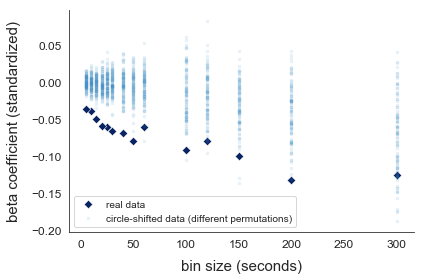

In [21]:
marker_real = 'D'
marker_shuffled = '.'

sns.scatterplot(x="bin_size", y="beta", data=df_real, marker=marker_real, color='#0A2463', label="real data")
sns.scatterplot(x="bin_size", y="betas", data=df_shifted, marker=marker_shuffled, 
                color='#3E92CC', alpha=0.1, edgecolor='#3E92CC', 
                label="circle-shifted data (different permutations)")

plt.xlabel('bin size (seconds)', fontsize=15, labelpad=10)
plt.ylabel('beta coefficient (standardized)', fontsize=15, labelpad=10)

plt.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(base_dir, 'Figures', 'within_convo_analysis_friends.png'), dpi=300)


# Quantify performance

How many times (out of 100) does the real beta outperform the circle-shifted data?

In [22]:
performance = pd.DataFrame()
performance = performance.fillna(0)
counter = 0

for i in range(len(df_real)):
    
    bin_size = df_real.at[i, 'bin_size']
    beta_real = df_real.at[i, 'beta']
    data_shifted_bin_subset = df_shifted.loc[df_shifted['bin_size'] == bin_size]
    data_shifted_bin_subset_beat_num = data_shifted_bin_subset.loc[data_shifted_bin_subset['betas'] > beta_real]
    
    performance.at[counter, 'bin_size'] = bin_size
    performance.at[counter, 'beta_beats_null'] = len(data_shifted_bin_subset_beat_num)

    counter += 1

In [23]:
performance

,bin_size,beta_beats_null
0,300.0,82.0
1,200.0,100.0
2,150.0,98.0
3,120.0,98.0
4,100.0,99.0
5,60.0,99.0
6,50.0,100.0
7,40.0,100.0
8,30.0,100.0
9,25.0,100.0
